In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  
import talib
import math

#Classification Model
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Feature Selection Wrapper methods
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize

#Regression Model
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from datetime import date, timedelta
import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
N225y5 = pdr.get_data_yahoo("^N225", start="2016-10-31", end="2021-10-31")

N225y7 = pdr.get_data_yahoo("^N225", start="2014-10-31", end="2021-10-31")

HSIy5 = pdr.get_data_yahoo("^HSI", start="2016-10-31", end="2021-10-31")

HSIy7 = pdr.get_data_yahoo("^HSI", start="2014-10-31", end="2021-10-31")

DJIy5 = pdr.get_data_yahoo("^DJI", start="2016-10-31", end="2021-10-31")

DJIy7 = pdr.get_data_yahoo("^DJI", start="2014-10-31", end="2021-10-31")

SSEy5 = pdr.get_data_yahoo("000001.SS", start="2016-10-31", end="2021-10-31")

SSEy7 = pdr.get_data_yahoo("000001.SS", start="2014-10-31", end="2021-10-31")

## Targeting Data

In [3]:
def at(df):
    data = df.copy()
    
    next = 7
    for i in range(3):
        if (i == 0):
            data_compare = data.copy()
        data_compare["{}".format(i+next)] = data_compare.Close.shift(-i-next)
        
    
    conditions = [
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) > data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) > data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) > data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) <= -data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) <= -data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) <= -data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) <= data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) <= data_compare['Open']*0.0175),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) <= data_compare['Open']*0.0175)
    ]
    values = [2,2,2,0,0,0,1,1,1]
    df['Target'] = np.select(conditions, values)
    df.Target = df.Target.shift(-1)
#     print(data[data["Target"] == 1]["Open"].count(),data[data["Target"] == 0]["Open"].count())
    df.dropna(inplace=True)

In [4]:
def addindicator(df):
    data = df.copy()
    data['SMA20'] = talib.SMA(data['Close'], timeperiod=14)
    data['MACD'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0] / \
                     talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0].mean()
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14) / talib.RSI(data['Close'], timeperiod=14).mean()
    data['EMA'] = talib.EMA(data['Close'], timeperiod=14)
    data['CMO'] = talib.CMO(data['Close'], timeperiod=14)
    data['slowk'], data['slowd'] = talib.STOCH(high=data['High'],
                                low=data['Low'],
                                fastk_period=9,
                                close=data['Close'],
                                slowk_period=3,
                                slowk_matype=0,
                                slowd_period=6,
                                slowd_matype=0)
    data['OBV'] = talib.OBV(data["Close"], data["Volume"])
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['ADOSC'] = talib.ADOSC(data['High'], data['Low'], data['Close'], data["Volume"], fastperiod=3, slowperiod=10)
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['HT_DCPHASE'] = talib.HT_DCPHASE(data['Close'])
    data['APO'] = talib.APO(data['Close'], fastperiod=12, slowperiod=26, matype=0)
    data.dropna(inplace=True)
    return data

In [5]:
at(N225y5)
at(N225y7)
at(HSIy5)
at(HSIy7)
at(DJIy5)
at(DJIy7)
at(SSEy5)
at(SSEy7)

In [6]:
N225y5_ind = addindicator(N225y5)
HSIy5_ind = addindicator(HSIy5)
DJIy5_ind = addindicator(DJIy5)
SSEy5_ind = addindicator(SSEy5)
N225y7_ind = addindicator(N225y7)
HSIy7_ind = addindicator(HSIy7)
DJIy7_ind = addindicator(DJIy7)
SSEy7_ind = addindicator(SSEy7)

In [7]:
training5 = [N225y5_ind, HSIy5_ind, DJIy5_ind, SSEy5_ind]
training7 = [N225y7_ind, HSIy7_ind, DJIy7_ind, SSEy7_ind]
ind_list = ['SMA20','MACD','RSI','EMA','CMO','slowk','slowd','OBV','ADX', 'ADOSC', 'ATR', 'HT_DCPHASE', 'APO']
label = ['N225','HSI','DJI','SSE']

## Classification Training & Prediction Defined

In [8]:
def model_train(df, model):
    scaler = StandardScaler()
    flag = 0
    total = []
    for i in df:
        data = i.copy()
        x = scaler.fit_transform(data.iloc[:,7:])
        x = pd.DataFrame(x, columns = ind_list)
        y = data.iloc[:, 6].values
        if (flag == 0):
            a_y = y
        else:
            a_y = np.concatenate((a_y, y), axis=0)
        total.append(x)
        flag += 1
    a_x = pd.concat(total)
    rfe = RFE(model)
    rfe = rfe.fit(a_x[ind_list],a_y)
    result = pd.Series(rfe.support_, index = ind_list)
    result = result[result==False].index
    a_x = a_x.drop(result, axis='columns').values
    model.fit(a_x,a_y)
    return (model, result)

def model_pred(df, result, model):
    scaler = StandardScaler()
    for i in df:
        data = i.copy()
        data = data.drop(result, axis='columns')
        x = data.iloc[:,7:]
        y = data.iloc[:, 6].values
        x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.15, random_state=0)
        real = make_pipeline(scaler, model)
        real.fit(x_train,y_train)
        
        yt_pred = real.predict(x_train)
        predx_accur = metrics.accuracy_score(y_train, yt_pred)
        predx_recall = metrics.recall_score(y_train, yt_pred, average='macro')
        predx_preci = metrics.precision_score(y_train, yt_pred , average='macro')
        cmx = confusion_matrix(y_train, yt_pred)
        F1x = metrics.f1_score(y_train, yt_pred , average='macro')
        

        y_pred = real.predict(x_test)
        pred_accur = metrics.accuracy_score(y_test, y_pred)
        pred_recall = metrics.recall_score(y_test, y_pred, average='macro')
        pred_preci = metrics.precision_score(y_test, y_pred , average='macro')
        cm = confusion_matrix(y_test, y_pred)

        F1 = metrics.f1_score(y_test, y_pred , average='macro')
        print('Train Accuracy Score:', predx_accur)
        print('Train Recall Score:', predx_recall)
        print('Train Precition Score:',predx_preci)
        print('Train Confusion matrix:')
        print(cmx)
        print('Train F1 Score:',F1x)
        print('\n----------------------------------\n')
        print('Test Accuracy Score:', pred_accur)
        print('Test Recall Score:', pred_recall)
        print('Test Precition Score:',pred_preci)
        print('Test Confusion matrix:')
        print(cm)
        print('Test F1 Score:',F1)
        
    return (y_test,y_pred,pred_accur,pred_recall,pred_preci)

## AUC plot function

In [9]:
def auc(df):
    data = []
    for i in df:
#         print(i)
        if (i == 0):
            data.append([1,0,0])
        if (i == 1):
            data.append([0,1,0])
        if (i == 2):
            data.append([0,0,1])
    return data

def plot(y_test, y_pred):
    model = label_binarize(y_test, classes=[-1, 0,1])
    n_classes = model.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test = np.array(auc(y_test))
    y_pred = np.array(auc(y_pred))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        colors = cycle(['blue', 'red', 'green'])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    return (fpr["macro"],tpr["macro"])

In [10]:
def score_report(model,label,model_acc,model_recall,model_preci):
    data = {'label':label,'accuracy':model_acc,'recall':model_recall,'preci':model_preci}
    df = pd.DataFrame(data,columns=['label','accuracy','recall','preci'])
    plt.figure(figsize=[10, 7])
    plt.plot(df.label,df.accuracy,marker='o',label='Accuracy',linewidth=3)
    plt.plot(df.label,df.recall,marker='o',label='Recall',linewidth=3)
    plt.plot(df.label,df.preci,marker='o',label='Precition',linewidth=3)

    for x,y in zip(df.label,df.accuracy):
        label = "{:.2f}".format(y)
        plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center') 

    for x,y in zip(df.label,df.recall):
        label = "{:.2f}".format(y)
        plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center') 

    for x,y in zip(df.label,df.preci):
        label = "{:.2f}".format(y)
        plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center') 


    plt.title(model+' Score')
    plt.legend()
    plt.show()
    
def AUC_report(model,model_fpr,model_tpr):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10,7))

    for i in range(4):
        fpr["macro"] = model_fpr[i]
        tpr["macro"] = model_tpr[i]
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
        plt.plot(fpr["macro"],tpr["macro"],label=label[i]+" (area = {0:0.2f})".format(roc_auc["macro"]),linewidth=4)

    plt.plot([0, 1], [0, 1],linestyle="--",color="black",linewidth=4,)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model +' AUC')
    plt.legend(loc="lower right")
    plt.show()

## Using LSVC Classifier Model


N225
Train Accuracy Score: 0.44659206510681587
Train Recall Score: 0.4254085584375724
Train Precition Score: 0.45082639423012694
Train Confusion matrix:
[[203 140  29]
 [127 185  30]
 [107 111  51]]
Train F1 Score: 0.4155206115611066

----------------------------------

Test Accuracy Score: 0.4540229885057471
Test Recall Score: 0.4391475962851208
Test Precition Score: 0.4803794424047589
Test Confusion matrix:
[[37 24  1]
 [22 32  7]
 [18 23 10]]
Test F1 Score: 0.4264573434420165

HSI
Train Accuracy Score: 0.48185483870967744
Train Recall Score: 0.4316810264680726
Train Precition Score: 0.4559952157781683
Train Confusion matrix:
[[277  14 113]
 [147  19  80]
 [145  15 182]]
Train F1 Score: 0.4020985414725175

----------------------------------

Test Accuracy Score: 0.4147727272727273
Test Recall Score: 0.3982415706359368
Test Precition Score: 0.435
Test Confusion matrix:
[[43  2 26]
 [35  6 14]
 [22  4 24]]
Test F1 Score: 0.36769369526635826

DJI
Train Accuracy Score: 0.542857142857142

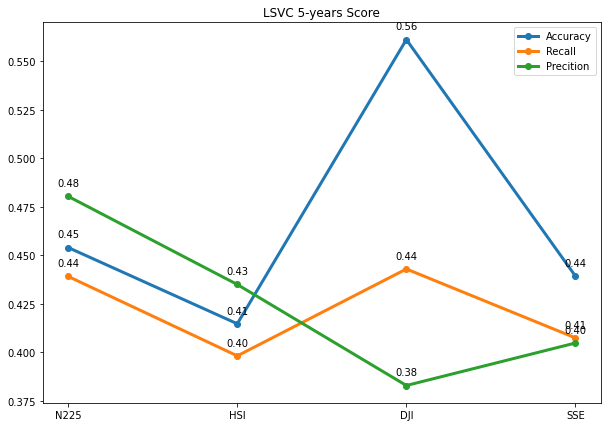

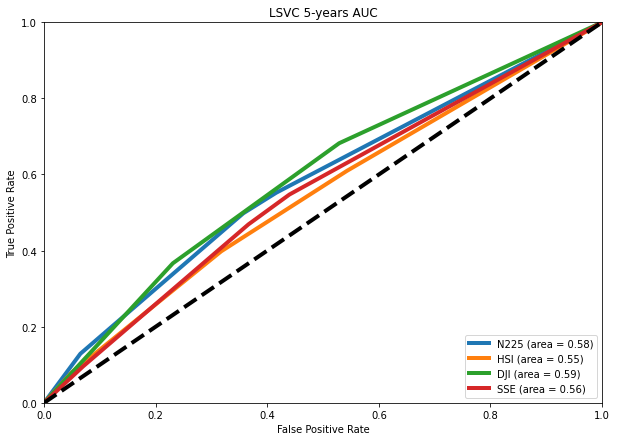

In [31]:
lsvc =  LinearSVC(random_state=0, tol=1e-5,dual=False,C=1,max_iter= 2000,penalty='l2')
model = 'LSVC 5-years'
c = 0
lsvc_acc = []
lsvc_recall = []
lsvc_preci = []
lsvc_fpr = []
lsvc_tpr = []
for i in training5:
    print("\n"+label[c])
    x = model_train(training5[c:c+1], lsvc)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training5[c:c+1], np.array(x[1]), x[0])
    lsvc_acc.append(asd)
    lsvc_recall.append(asd2)
    lsvc_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lsvc_fpr.append(ram1)
    lsvc_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lsvc_acc,lsvc_recall,lsvc_preci)
AUC_report(model,lsvc_fpr,lsvc_tpr)


N225
Train Accuracy Score: 0.4337866857551897
Train Recall Score: 0.41200813144980636
Train Precition Score: 0.4263653234967048
Train Confusion matrix:
[[348 157  39]
 [196 191  53]
 [217 129  67]]
Train F1 Score: 0.3947249527402199

----------------------------------

Test Accuracy Score: 0.4574898785425101
Test Recall Score: 0.43876054272093884
Test Precition Score: 0.4503459503459504
Test Confusion matrix:
[[60 29 12]
 [29 37  8]
 [31 25 16]]
Test F1 Score: 0.42925585670683714

HSI
Train Accuracy Score: 0.43120567375886526
Train Recall Score: 0.38218752511598036
Train Precition Score: 0.3755896315086391
Train Confusion matrix:
[[386  25 158]
 [220  15 120]
 [260  19 207]]
Train F1 Score: 0.3456024782660528

----------------------------------

Test Accuracy Score: 0.40562248995983935
Test Recall Score: 0.3700062421972534
Test Precition Score: 0.3760822510822511
Test Confusion matrix:
[[58  2 29]
 [44  2 18]
 [52  3 41]]
Test F1 Score: 0.3264521524086968

DJI
Train Accuracy Score: 0.

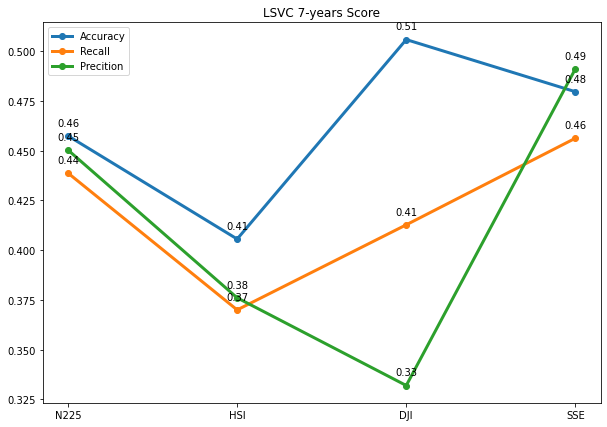

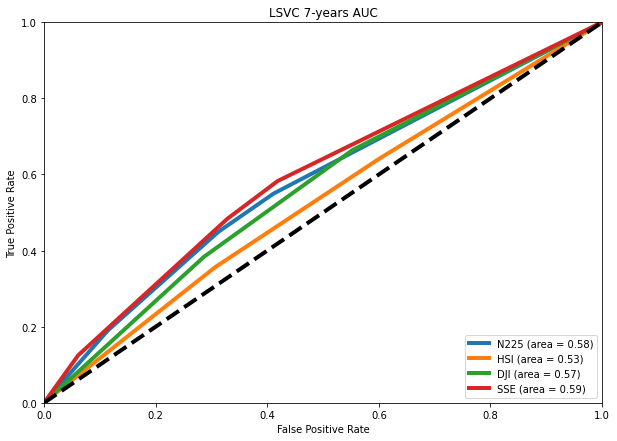

In [32]:
lsvc =  LinearSVC(random_state=0, tol=1e-5,dual=False,C=1,max_iter= 2000,penalty='l2')
model = 'LSVC 7-years'
c = 0
lsvc_acc = []
lsvc_recall = []
lsvc_preci = []
lsvc_fpr = []
lsvc_tpr = []

for i in training7:
    print("\n"+label[c])
    x = model_train(training7[c:c+1], lsvc)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training7[c:c+1], np.array(x[1]), x[0])
    lsvc_acc.append(asd)
    lsvc_recall.append(asd2)
    lsvc_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lsvc_fpr.append(ram1)
    lsvc_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lsvc_acc,lsvc_recall,lsvc_preci)
AUC_report(model,lsvc_fpr,lsvc_tpr)

## Using Gradient Boosting Classifier Model


N225
Train Accuracy Score: 0.9633774160732451
Train Recall Score: 0.9634251048468329
Train Precition Score: 0.9643845915813648
Train Confusion matrix:
[[364   8   0]
 [ 14 322   6]
 [  0   8 261]]
Train F1 Score: 0.9638686957370014

----------------------------------

Test Accuracy Score: 0.7183908045977011
Test Recall Score: 0.7238311506516938
Test Precition Score: 0.7270212194466827
Test Confusion matrix:
[[48 11  3]
 [20 35  6]
 [ 5  4 42]]
Test F1 Score: 0.7217570511688157

HSI
Train Accuracy Score: 0.9637096774193549
Train Recall Score: 0.9600915911017717
Train Precition Score: 0.9624459625604529
Train Confusion matrix:
[[393   5   6]
 [  6 229  11]
 [  3   5 334]]
Train F1 Score: 0.961146988350181

----------------------------------

Test Accuracy Score: 0.6534090909090909
Test Recall Score: 0.6471532223644899
Test Precition Score: 0.6279295761053638
Test Confusion matrix:
[[56 11  4]
 [21 15 19]
 [ 4  2 44]]
Test F1 Score: 0.6168082135108134

DJI
Train Accuracy Score: 0.9733990

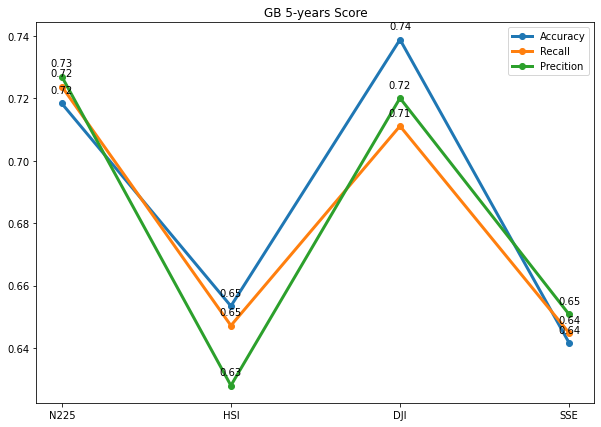

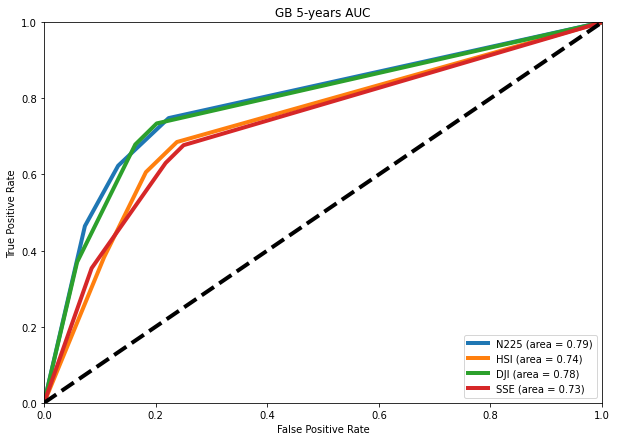

In [33]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0,min_samples_split=0.005,min_samples_leaf=0.005)
model = 'GB 5-years'
c = 0
gb_acc = []
gb_recall = []
gb_preci = []
gb_fpr = []
gb_tpr = []

for i in training5:
    print("\n"+label[c])
    x = model_train(training5[c:c+1], gb)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training5[c:c+1], np.array(x[1]), x[0])
    gb_acc.append(asd)
    gb_recall.append(asd2)
    gb_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    gb_fpr.append(ram1)
    gb_tpr.append(ram2)
    c = c+1
    
score_report(model,label,gb_acc,gb_recall,gb_preci)
AUC_report(model,gb_fpr,gb_tpr)


N225
Train Accuracy Score: 0.9198282032927703
Train Recall Score: 0.9167949614360381
Train Precition Score: 0.9212806398292631
Train Confusion matrix:
[[520  19   5]
 [ 36 389  15]
 [ 13  24 376]]
Train F1 Score: 0.91871866018422

----------------------------------

Test Accuracy Score: 0.7530364372469636
Test Recall Score: 0.7322309933696073
Test Precition Score: 0.7367211922359194
Test Confusion matrix:
[[93  3  5]
 [15 42 17]
 [ 5 16 51]]
Test F1 Score: 0.7316097921963213

HSI
Train Accuracy Score: 0.9014184397163121
Train Recall Score: 0.8858050038655904
Train Precition Score: 0.9057313686900748
Train Confusion matrix:
[[545  11  13]
 [ 44 271  40]
 [ 21  10 455]]
Train F1 Score: 0.8925725918748392

----------------------------------

Test Accuracy Score: 0.6987951807228916
Test Recall Score: 0.6684222846441948
Test Precition Score: 0.6839007350869858
Test Confusion matrix:
[[70  9 10]
 [25 26 13]
 [11  7 78]]
Test F1 Score: 0.6667976427577998

DJI
Train Accuracy Score: 0.93628808

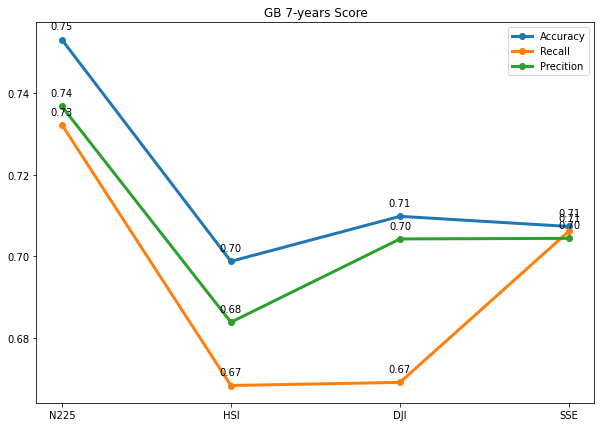

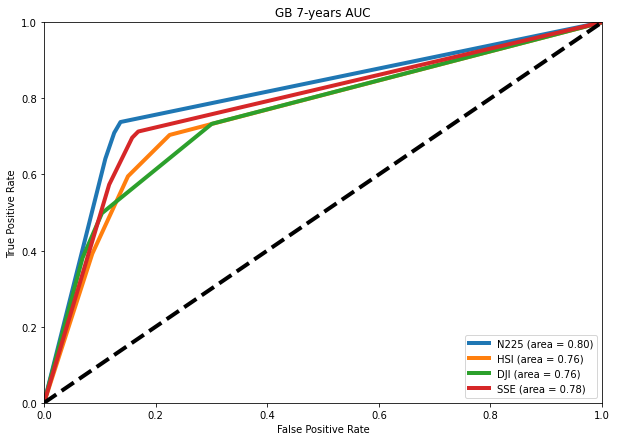

In [34]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0,min_samples_split=0.005,min_samples_leaf=0.005)
model = 'GB 7-years'
c = 0
gb_acc = []
gb_recall = []
gb_preci = []
gb_fpr = []
gb_tpr = []

for i in training7:
    print("\n"+label[c])
    x = model_train(training7[c:c+1], gb)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training7[c:c+1], np.array(x[1]), x[0])
    gb_acc.append(asd)
    gb_recall.append(asd2)
    gb_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    gb_fpr.append(ram1)
    gb_tpr.append(ram2)
    c = c+1
    
score_report(model,label,gb_acc,gb_recall,gb_preci)
AUC_report(model,gb_fpr,gb_tpr)

## Using LDA method


N225
Train Accuracy Score: 0.43641912512716174
Train Recall Score: 0.41814227144255356
Train Precition Score: 0.4308608907082652
Train Confusion matrix:
[[195 136  41]
 [124 176  42]
 [102 109  58]]
Train F1 Score: 0.4120223120887075

----------------------------------

Test Accuracy Score: 0.45977011494252873
Test Recall Score: 0.44916235487672945
Test Precition Score: 0.4724691358024691
Test Confusion matrix:
[[34 22  6]
 [22 32  7]
 [16 21 14]]
Test F1 Score: 0.4456750936118803

HSI
Train Accuracy Score: 0.48286290322580644
Train Recall Score: 0.4338352320469531
Train Precition Score: 0.47157242869257665
Train Confusion matrix:
[[292  14  98]
 [136  28  82]
 [163  20 159]]
Train F1 Score: 0.41190440253597443

----------------------------------

Test Accuracy Score: 0.4375
Test Recall Score: 0.4124711907810499
Test Precition Score: 0.48696830692243537
Test Confusion matrix:
[[49  2 20]
 [33  7 15]
 [27  2 21]]
Test F1 Score: 0.3842640238866655

DJI
Train Accuracy Score: 0.5408866995

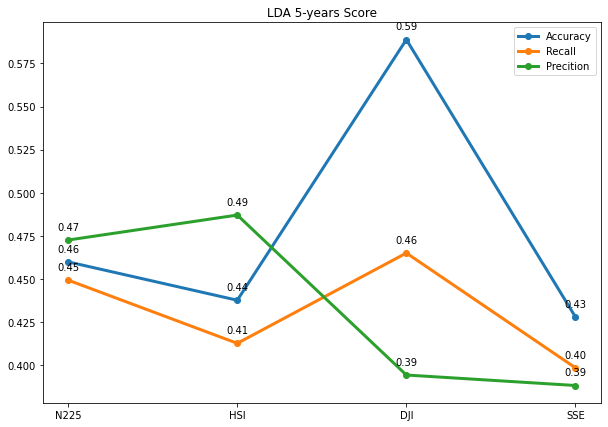

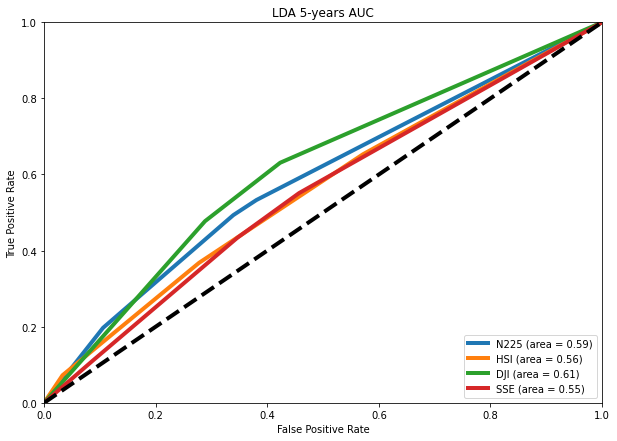

In [35]:
lda = LinearDiscriminantAnalysis(solver="svd")
model = 'LDA 5-years'
c = 0
lda_acc = []
lda_recall = []
lda_preci = []
lda_fpr = []
lda_tpr = []

for i in training5:
    print("\n"+label[c])
    x = model_train(training5[c:c+1], lda)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training5[c:c+1], np.array(x[1]), x[0])
    lda_acc.append(asd)
    lda_recall.append(asd2)
    lda_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lda_fpr.append(ram1) 
    lda_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lda_acc,lda_recall,lda_preci)
AUC_report(model,lda_fpr,lda_tpr)


N225
Train Accuracy Score: 0.4352183249821045
Train Recall Score: 0.4151276689412282
Train Precition Score: 0.4240302373214955
Train Confusion matrix:
[[340 151  53]
 [188 192  60]
 [213 124  76]]
Train F1 Score: 0.40168277779226

----------------------------------

Test Accuracy Score: 0.46153846153846156
Test Recall Score: 0.44471947194719474
Test Precition Score: 0.4574684574684575
Test Confusion matrix:
[[59 29 13]
 [29 37  8]
 [29 25 18]]
Test F1 Score: 0.4380311921596325

HSI
Train Accuracy Score: 0.43829787234042555
Train Recall Score: 0.3935489649864685
Train Precition Score: 0.4117521944242592
Train Confusion matrix:
[[384  30 155]
 [205  32 118]
 [256  28 202]]
Train F1 Score: 0.36911855814788286

----------------------------------

Test Accuracy Score: 0.40963855421686746
Test Recall Score: 0.37576076779026213
Test Precition Score: 0.36762820512820515
Test Confusion matrix:
[[60  5 24]
 [44  3 17]
 [52  5 39]]
Test F1 Score: 0.3369666048237477

DJI
Train Accuracy Score: 0.5

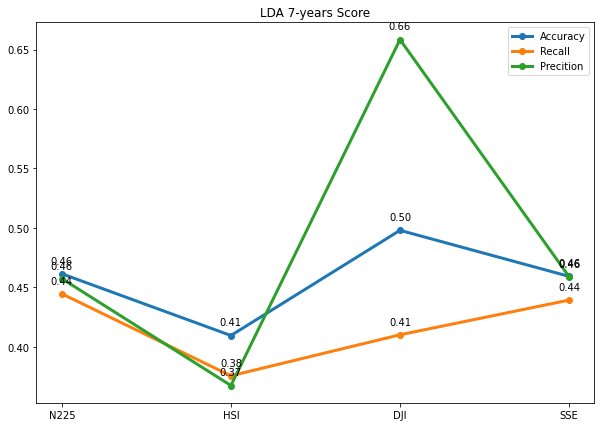

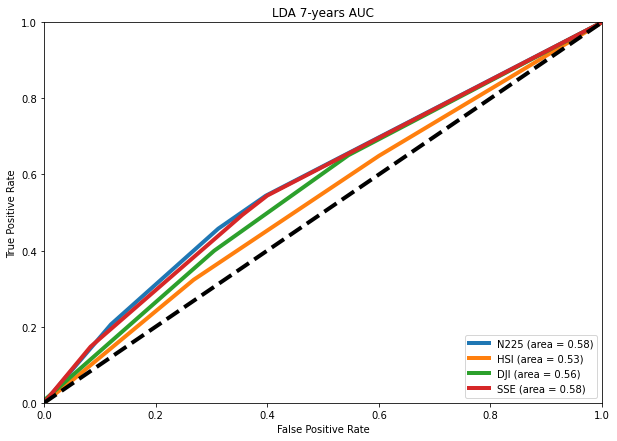

In [36]:
lda = LinearDiscriminantAnalysis(solver="svd")
model = 'LDA 7-years'
c = 0
lda_acc = []
lda_recall = []
lda_preci = []
lda_fpr = []
lda_tpr = []

for i in training7:
    print("\n"+label[c])
    x = model_train(training7[c:c+1], lda)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training7[c:c+1], np.array(x[1]), x[0])
    lda_acc.append(asd)
    lda_recall.append(asd2)
    lda_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lda_fpr.append(ram1) 
    lda_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lda_acc,lda_recall,lda_preci)
AUC_report(model,lda_fpr,lda_tpr)

## Using XGBoost Classifier Model


N225
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[372   0   0]
 [  0 342   0]
 [  0   0 269]]
Train F1 Score: 1.0

----------------------------------

Test Accuracy Score: 0.7241379310344828
Test Recall Score: 0.7314385652022134
Test Precition Score: 0.7300236406619386
Test Confusion matrix:
[[48 10  4]
 [20 34  7]
 [ 4  3 44]]
Test F1 Score: 0.7254120731075581

HSI
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[404   0   0]
 [  0 246   0]
 [  0   0 342]]
Train F1 Score: 1.0

----------------------------------

Test Accuracy Score: 0.6704545454545454
Test Recall Score: 0.6598719590268886
Test Precition Score: 0.6550058304181242
Test Confusion matrix:
[[60  5  6]
 [25 14 16]
 [ 2  4 44]]
Test F1 Score: 0.6256962398385358

DJI
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[371   0   0]
 [  0 436   0]
 [  0   0 208]]
Tra

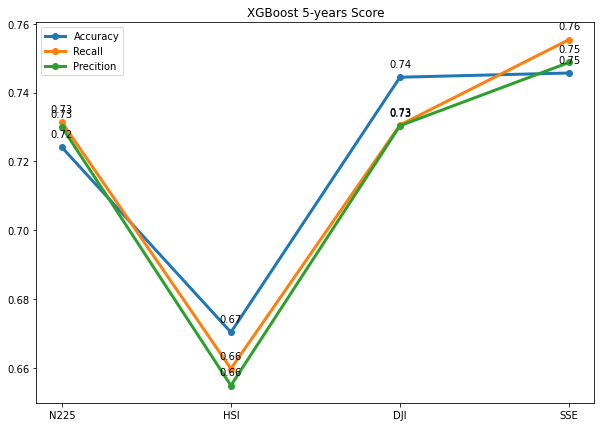

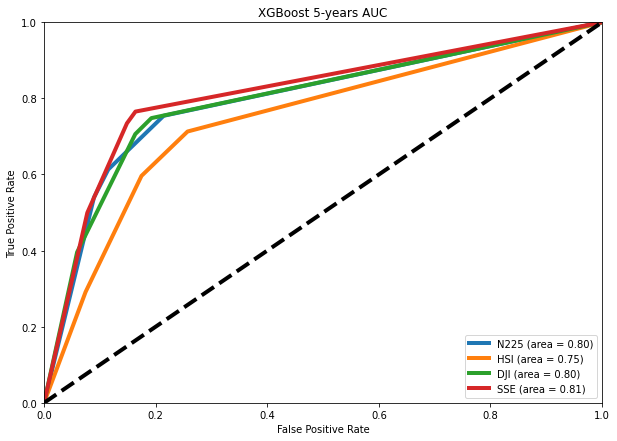

In [37]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, eval_metric='mlogloss', use_label_encoder=False)
model = 'XGBoost 5-years'
c = 0
xgb_acc = []
xgb_recall = []
xgb_preci = []
xgb_fpr = []
xgb_tpr = []

for i in training5:
    print("\n"+label[c])
    x = model_train(training5[c:c+1], xgb)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training5[c:c+1], np.array(x[1]), x[0])
    xgb_acc.append(asd)
    xgb_recall.append(asd2)
    xgb_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    xgb_fpr.append(ram1)
    xgb_tpr.append(ram2)
    c = c+1
    
score_report(model,label,xgb_acc,xgb_recall,xgb_preci)
AUC_report(model,xgb_fpr,xgb_tpr)


N225
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[544   0   0]
 [  0 440   0]
 [  0   0 413]]
Train F1 Score: 1.0

----------------------------------

Test Accuracy Score: 0.7327935222672065
Test Recall Score: 0.7212967918413463
Test Precition Score: 0.7197110359510107
Test Confusion matrix:
[[84  9  8]
 [20 40 14]
 [ 2 13 57]]
Test F1 Score: 0.7182654614778055

HSI
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[569   0   0]
 [  0 355   0]
 [  0   0 486]]
Train F1 Score: 1.0

----------------------------------

Test Accuracy Score: 0.751004016064257
Test Recall Score: 0.7314684769038702
Test Precition Score: 0.7335316744801058
Test Confusion matrix:
[[72 13  4]
 [17 36 11]
 [ 7 10 79]]
Test F1 Score: 0.7317743931351121

DJI
Train Accuracy Score: 1.0
Train Recall Score: 1.0
Train Precition Score: 1.0
Train Confusion matrix:
[[503   0   0]
 [  0 649   0]
 [  0   0 292]]
Trai

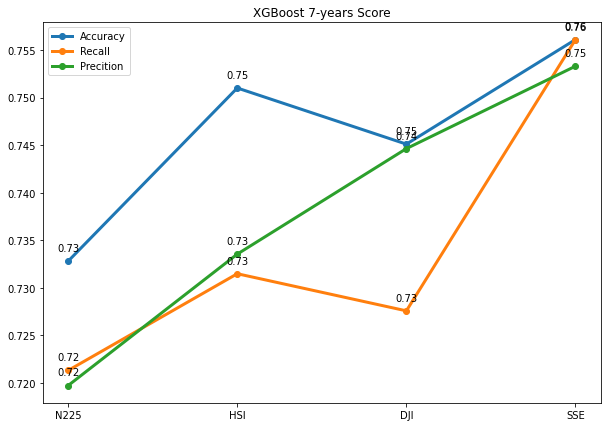

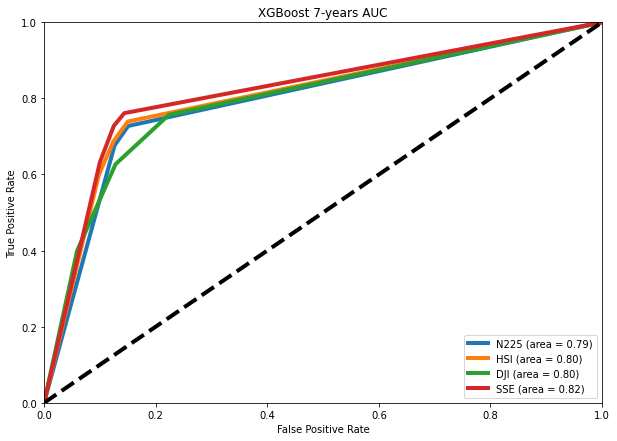

In [38]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, eval_metric='mlogloss', use_label_encoder=False)
model = 'XGBoost 7-years'
c = 0
xgb_acc = []
xgb_recall = []
xgb_preci = []
xgb_fpr = []
xgb_tpr = []

for i in training7:
    print("\n"+label[c])
    x = model_train(training7[c:c+1], xgb)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training7[c:c+1], np.array(x[1]), x[0])
    xgb_acc.append(asd)
    xgb_recall.append(asd2)
    xgb_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    xgb_fpr.append(ram1)
    xgb_tpr.append(ram2)
    c = c+1
    
score_report(model,label,xgb_acc,xgb_recall,xgb_preci)
AUC_report(model,xgb_fpr,xgb_tpr)

## Using LightGBM Classifier Model 


N225
Train Accuracy Score: 0.7833163784333672
Train Recall Score: 0.7768621430994176
Train Precition Score: 0.7927902453686073
Train Confusion matrix:
[[324  36  12]
 [ 69 250  23]
 [ 37  36 196]]
Train F1 Score: 0.781664032689361

----------------------------------

Test Accuracy Score: 0.6609195402298851
Test Recall Score: 0.6569595227479322
Test Precition Score: 0.675153435357883
Test Confusion matrix:
[[53  8  1]
 [21 31  9]
 [11  9 31]]
Test F1 Score: 0.654602939433984

HSI
Train Accuracy Score: 0.7721774193548387
Train Recall Score: 0.7427856178857081
Train Precition Score: 0.7786990086319093
Train Confusion matrix:
[[356  15  33]
 [ 72 130  44]
 [ 44  18 280]]
Train F1 Score: 0.7498755672584543

----------------------------------

Test Accuracy Score: 0.5965909090909091
Test Recall Score: 0.573657703798549
Test Precition Score: 0.5776023391812865
Test Confusion matrix:
[[61  4  6]
 [28 10 17]
 [11  5 34]]
Test F1 Score: 0.5397448604531733

DJI
Train Accuracy Score: 0.7793103448

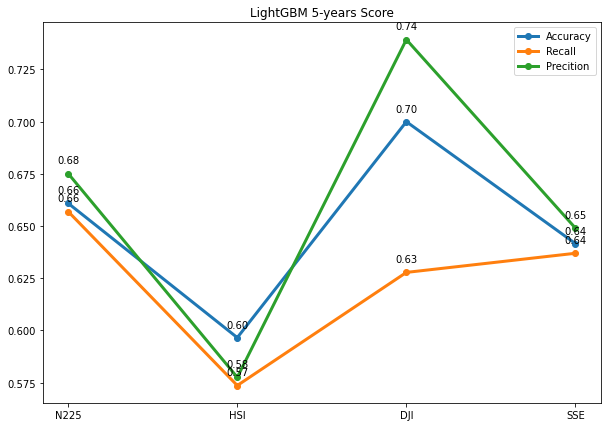

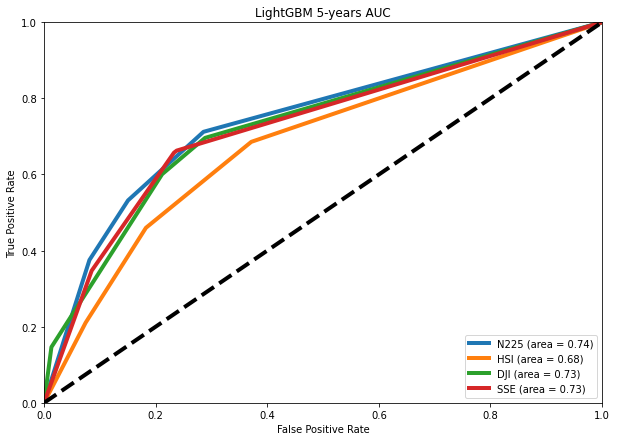

In [39]:
lgbm = lgb.LGBMClassifier(learning_rate=0.001,max_depth=-16, max_bin= 16,num_leaves = 32, num_iterations = 1000)
model = 'LightGBM 5-years'
c = 0
lgbm_acc = []
lgbm_recall = []
lgbm_preci = []
lgbm_fpr = []
lgbm_tpr = []

for i in training5:
    print("\n"+label[c])
    x = model_train(training5[c:c+1], lgbm)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training5[c:c+1], np.array(x[1]), x[0])
    lgbm_acc.append(asd)
    lgbm_recall.append(asd2)
    lgbm_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lgbm_fpr.append(ram1)
    lgbm_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lgbm_acc,lgbm_recall,lgbm_preci)
AUC_report(model,lgbm_fpr,lgbm_tpr)


N225
Train Accuracy Score: 0.7344309234073013
Train Recall Score: 0.7226045348802078
Train Precition Score: 0.7519317183202707
Train Confusion matrix:
[[478  48  18]
 [137 254  49]
 [ 87  32 294]]
Train F1 Score: 0.727758629509348

----------------------------------

Test Accuracy Score: 0.6518218623481782
Test Recall Score: 0.625967551710126
Test Precition Score: 0.6527146874324031
Test Confusion matrix:
[[87  8  6]
 [27 30 17]
 [20  8 44]]
Test F1 Score: 0.6245063523649166

HSI
Train Accuracy Score: 0.749645390070922
Train Recall Score: 0.7225059252067622
Train Precition Score: 0.7447435612271714
Train Confusion matrix:
[[485  36  48]
 [ 84 182  89]
 [ 64  32 390]]
Train F1 Score: 0.7262104578796986

----------------------------------

Test Accuracy Score: 0.6947791164658634
Test Recall Score: 0.666315543071161
Test Precition Score: 0.6970832218356972
Test Confusion matrix:
[[75  7  7]
 [16 26 22]
 [20  4 72]]
Test F1 Score: 0.665271984051197

DJI
Train Accuracy Score: 0.76038781163

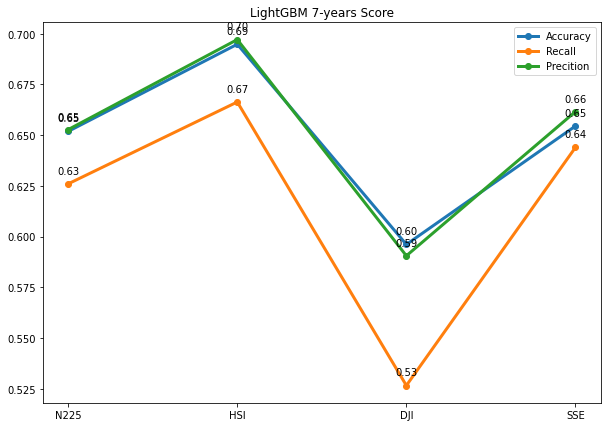

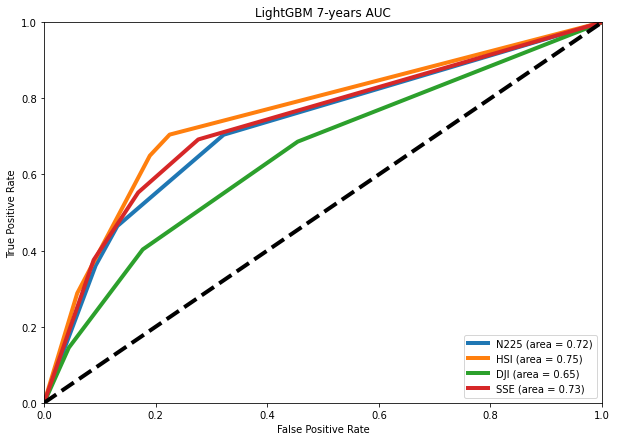

In [40]:
lgbm = lgb.LGBMClassifier(learning_rate=0.001,max_depth=-16, max_bin= 16,num_leaves = 32, num_iterations = 1000)
model = 'LightGBM 7-years'
c = 0
lgbm_acc = []
lgbm_recall = []
lgbm_preci = []
lgbm_fpr = []
lgbm_tpr = []

for i in training7:
    print("\n"+label[c])
    x = model_train(training7[c:c+1], lgbm)
    t_test,t_pred,asd,asd2,asd3 = model_pred(training7[c:c+1], np.array(x[1]), x[0])
    lgbm_acc.append(asd)
    lgbm_recall.append(asd2)
    lgbm_preci.append(asd3)
    ram1,ram2 = plot(t_test,t_pred)
    lgbm_fpr.append(ram1)
    lgbm_tpr.append(ram2)
    c = c+1
    
score_report(model,label,lgbm_acc,lgbm_recall,lgbm_preci)
AUC_report(model,lgbm_fpr,lgbm_tpr)

## Regression Prediction Defined

In [11]:
def regression_predict(training_data,model_regression_train,model_name,future_d):
    
    future_days = future_d
    prediction_data  = training_data.copy()
    
    #RFE feature Selection
    a = prediction_data.iloc[:,7:].values
    b = prediction_data.iloc[:, 2].values
    rfe = RFE(estimator=model_regression_train)
    rfe.fit(a, b)
    result = pd.Series(rfe.support_, index = ['SMA20','MACD','RSI','EMA','CMO','slowk','slowd','OBV','ADX', 'ADOSC', 'ATR', 'HT_DCPHASE', 'APO'])
    result = result[result==False].index
    prediction_data = prediction_data.drop(result, axis='columns')
    
    #Train Data
    prediction_data['Prediction']= prediction_data[['Open']].shift(-future_days)
    X = prediction_data.drop(['Prediction'], 1)[:-future_days]
    ktest = X
    X = np.array(X.iloc[:,7:].values)
    y = np.array(prediction_data['Prediction'])[:-future_days]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.15)
    
    #Fit mocel
    regression_model = model_regression_train.fit(x_train,y_train)
    regression_model.score(x_test,y_test)
    
    #KFold Cross validation
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    r2_scores = cross_val_score(regression_model, x_train,y_train, scoring='r2', cv=cv, n_jobs=1)
    rmse_scores = cross_val_score(regression_model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1)
    print("R-Sqared n_splits=5: ",r2_scores)
    print("Negative Root Mean Squared Error: ",rmse_scores)
    
    #Predict future
    x_future = prediction_data.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.iloc[:,7:]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)
    regression_prediction = regression_model.predict(x_future)
    
    #find r-squred & mse & rmse
    y_pred = regression_model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    root_mean_squared_error = sqrt(mse)
    R_squre = r2_score(y_test,regression_model.predict(x_test))
    print("R-Sqared : ",R_squre)
    print('Mean Squared Error : ' ,mse)
    print('Root Mean Squared Error : ' ,root_mean_squared_error)

    #plot graph
    predictions = regression_prediction
    valid = prediction_data[X.shape[0]:]
    valid['Prediction'] = predictions

    plt.figure(figsize=(10,7))
    plt.title( model_name +' Prediction : %d days'%future_days)
    plt.xlabel('Years')
    plt.ylabel('Open Price USD($)')
    plt.plot(valid['Open'],color='purple',linewidth=2)
    plt.plot(valid['Prediction'],marker='o',linewidth=2)
    plt.legend(['Real Open Price', 'Prediction'])
    plt.show()
    
    result = valid['Open']-valid['Prediction']
    valid['result']= result
    

    return valid

## DecisionTreeRegressor

N225 5-years
R-Sqared n_splits=5:  [0.95167929 0.95124533 0.93209367 0.95544181 0.97256589]
Negative Root Mean Squared Error:  [-708.73655942 -793.6456329  -828.13785429 -644.06347641 -459.86438725]
R-Sqared :  0.9670749746845707
Mean Squared Error :  300908.55417897657
Root Mean Squared Error :  548.551323194992


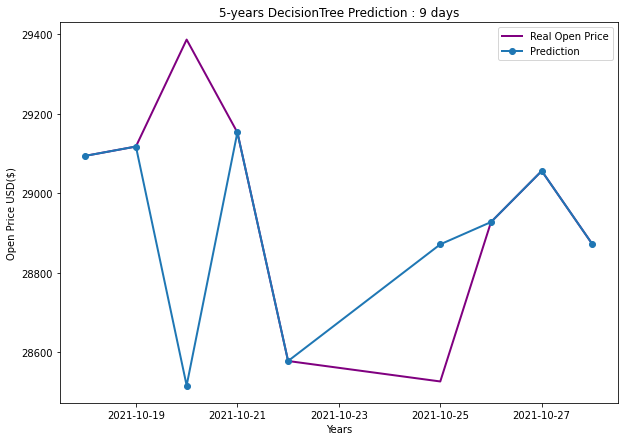



HSI 5-years
R-Sqared n_splits=5:  [0.83484264 0.81155329 0.72702822 0.78607592 0.68315283]
Negative Root Mean Squared Error:  [ -895.98847782  -945.02054623 -1063.38248219  -846.39989365
 -1191.04151969]
R-Sqared :  0.8305549414136083
Mean Squared Error :  747400.4147949219
Root Mean Squared Error :  864.5232297601505


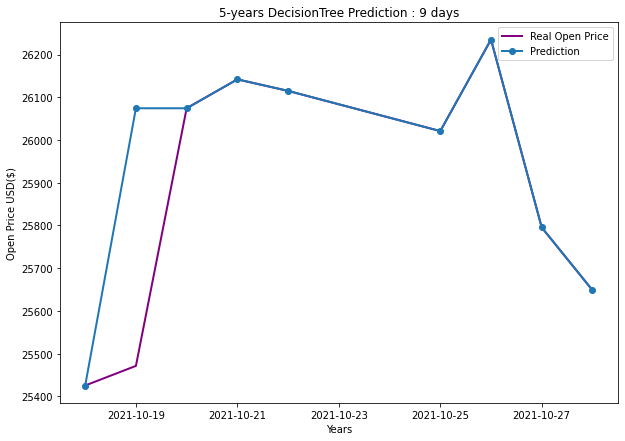



DJI 5-years
R-Sqared n_splits=5:  [0.929491   0.99049922 0.96666764 0.98486519 0.98035353]
Negative Root Mean Squared Error:  [-783.48710839 -459.19962849 -763.93888296 -550.96222306 -502.82691843]
R-Sqared :  0.972948061776656
Mean Squared Error :  342391.7463099019
Root Mean Squared Error :  585.1425008576132


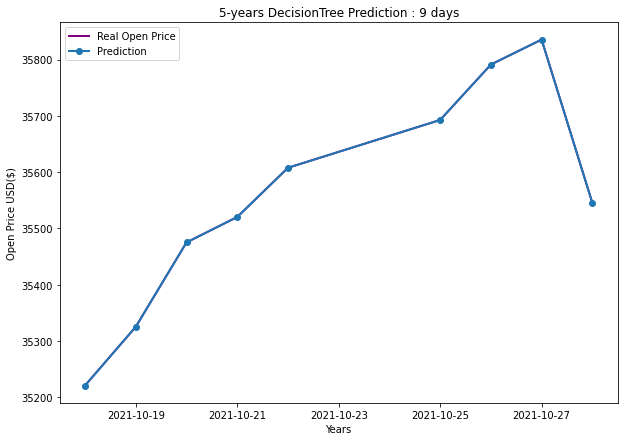



SSE 5-years
R-Sqared n_splits=5:  [0.93173366 0.93042055 0.94373223 0.89330598 0.92679373]
Negative Root Mean Squared Error:  [-77.33919498 -74.34182711 -70.45290074 -96.65117078 -77.79402872]
R-Sqared :  0.9368155773059644
Mean Squared Error :  5670.6079486601575
Root Mean Squared Error :  75.3034391555934


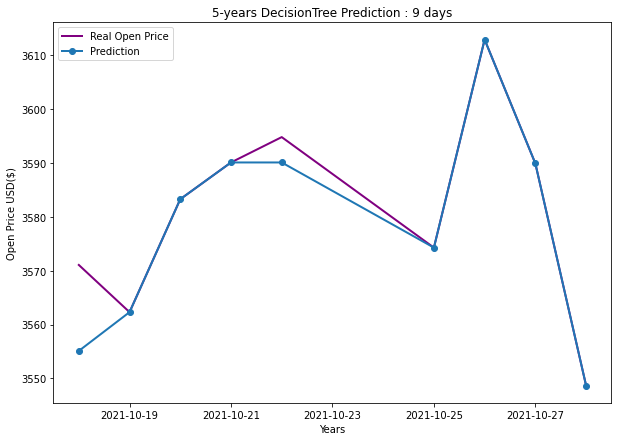

In [42]:
model_regression_train = DecisionTreeRegressor()
model_name  = '5-years DecisionTree'
future_d = 9
d=0

for j in training5:
    print(label[d]+" 5-years")
    
    reg_data = regression_predict(training5[d],model_regression_train,model_name,future_d)
    d=d+1
    
    print("\n")

N225 7-years
R-Sqared n_splits=5:  [0.96906919 0.94909548 0.96454426 0.92516952 0.95837375]
Negative Root Mean Squared Error:  [-656.15421854 -830.48878917 -689.28033791 -969.84969028 -749.5710871 ]
R-Sqared :  0.9550119055623948
Mean Squared Error :  537409.1365181528
Root Mean Squared Error :  733.0819439313403


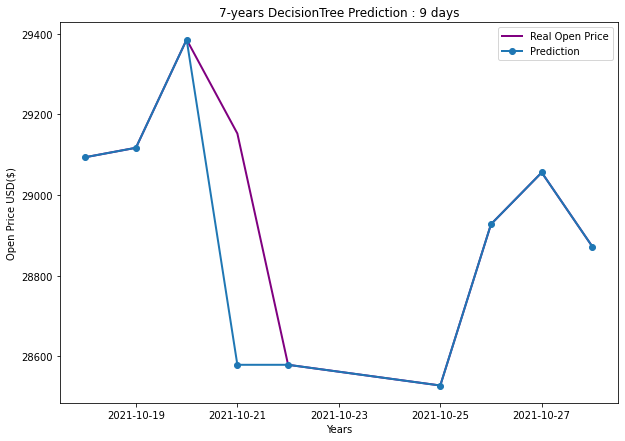



HSI 7-years
R-Sqared n_splits=5:  [0.93239498 0.93671038 0.92924706 0.92020713 0.93550472]
Negative Root Mean Squared Error:  [-749.69618475 -749.8115244  -774.64955949 -800.82056745 -831.28291691]
R-Sqared :  0.944513392885552
Mean Squared Error :  469731.36836193455
Root Mean Squared Error :  685.3695122792774


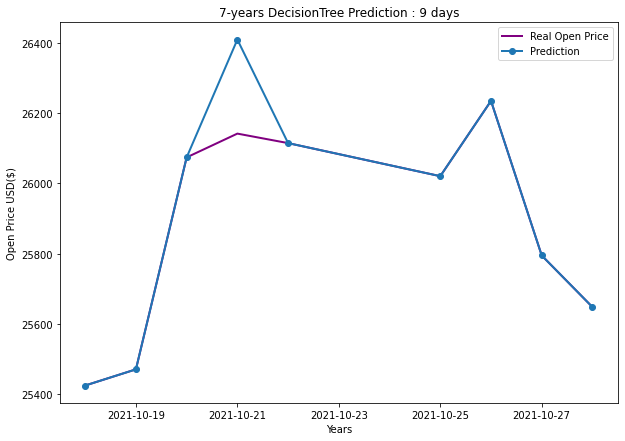



DJI 7-years
R-Sqared n_splits=5:  [0.98365523 0.98875395 0.98884559 0.9831016  0.99374275]
Negative Root Mean Squared Error:  [-657.90856915 -556.00346688 -561.92523877 -653.23246722 -498.76600316]
R-Sqared :  0.9892330256257034
Mean Squared Error :  288043.421652088
Root Mean Squared Error :  536.6967688109255


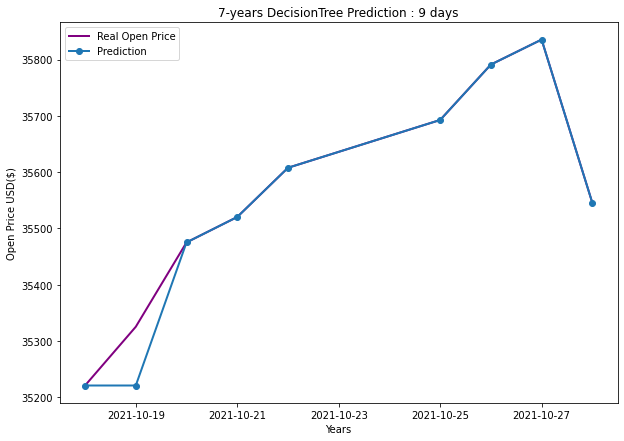



SSE 7-years
R-Sqared n_splits=5:  [0.89695147 0.85977166 0.89087016 0.87138726 0.92219992]
Negative Root Mean Squared Error:  [-127.45114458 -160.66694819 -136.19168171 -116.27735799 -100.5984839 ]
R-Sqared :  0.941925796606063
Mean Squared Error :  10485.33235300536
Root Mean Squared Error :  102.39791185861829


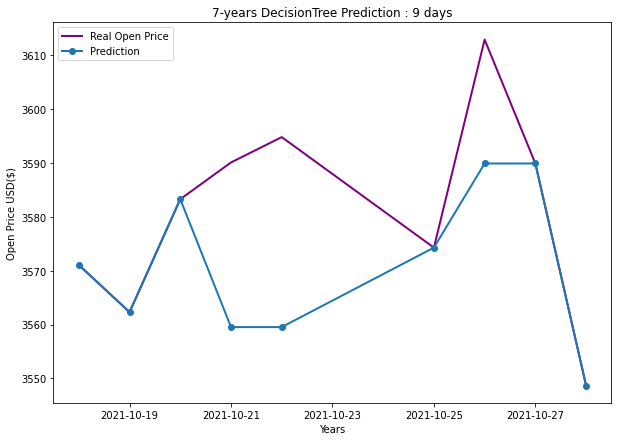

In [43]:
model_regression_train = DecisionTreeRegressor(max_depth=1000)
model_name  = '7-years DecisionTree'
future_d = 9
d=0

for j in training7:
    print(label[d]+" 7-years")
    reg_data = regression_predict(training7[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

## ExtraTreeRegressor

N225 5-years
R-Sqared n_splits=5:  [0.97998237 0.98309695 0.984553   0.98246172 0.98709249]
Negative Root Mean Squared Error:  [-441.46976826 -398.73353901 -402.9297275  -371.61082266 -373.47863775]
R-Sqared :  0.9883654369930541
Mean Squared Error :  105383.27460258419
Root Mean Squared Error :  324.62790176228566


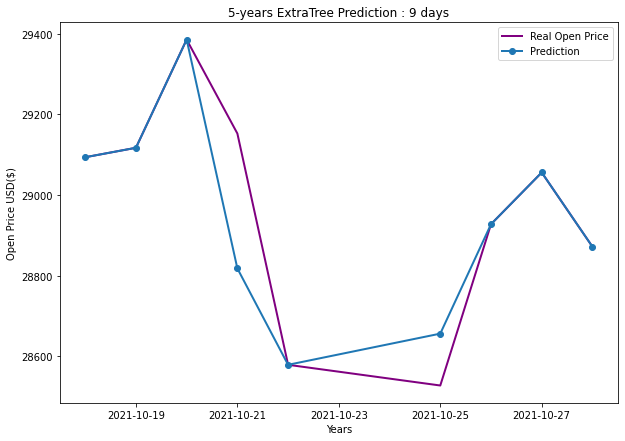



HSI 5-years
R-Sqared n_splits=5:  [0.86434366 0.89765884 0.91443502 0.91120432 0.90422003]
Negative Root Mean Squared Error:  [-715.21969892 -720.56928421 -668.7853779  -612.50150639 -606.1212133 ]
R-Sqared :  0.9155555776863994
Mean Squared Error :  398879.61010841967
Root Mean Squared Error :  631.5691649442836


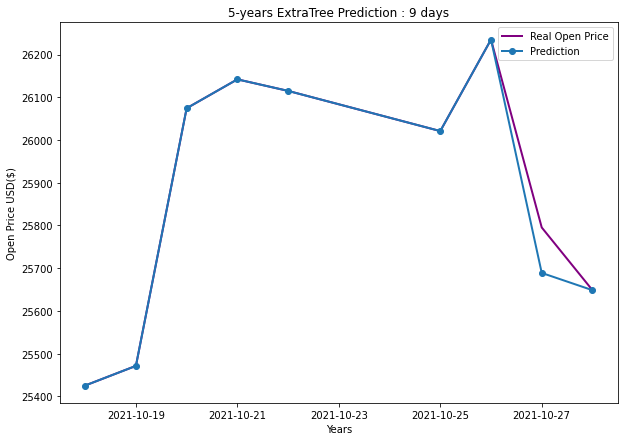



DJI 5-years
R-Sqared n_splits=5:  [0.99306037 0.99039932 0.99518352 0.9961198  0.9919972 ]
Negative Root Mean Squared Error:  [-335.7864461  -369.82037367 -272.44427578 -245.12482023 -378.02609559]
R-Sqared :  0.9936074478115781
Mean Squared Error :  96051.18907141872
Root Mean Squared Error :  309.92126269654153


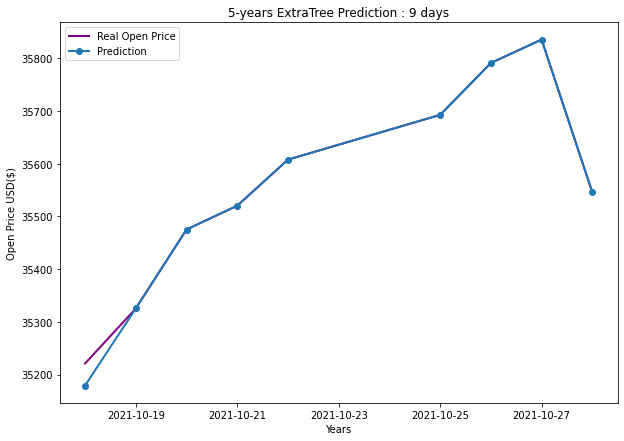



SSE 5-years
R-Sqared n_splits=5:  [0.96420701 0.9837012  0.98294798 0.96745892 0.97487934]
Negative Root Mean Squared Error:  [-55.70747816 -36.83676432 -40.79306796 -50.70816588 -45.2830071 ]
R-Sqared :  0.9805080603101011
Mean Squared Error :  1629.7117196309957
Root Mean Squared Error :  40.3696881289786


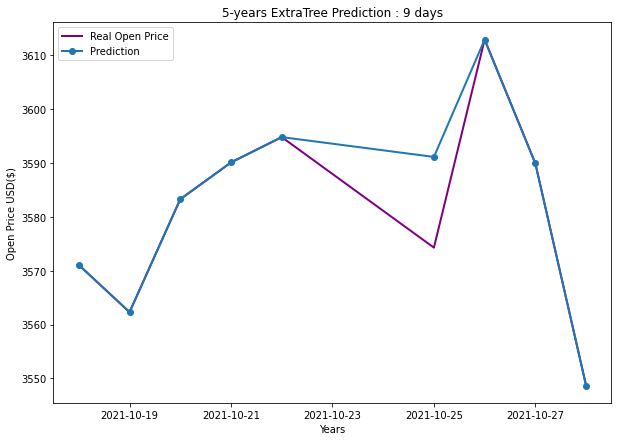

In [44]:
model_regression_train = ExtraTreesRegressor(n_estimators=100, random_state=0)
model_name  = '5-years ExtraTree'
future_d = 9
d=0

for j in training5:
    print(label[d]+" 5-years")
    reg_data = regression_predict(training5[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

N225 7-years
R-Sqared n_splits=5:  [0.9862403  0.9913545  0.98314451 0.98628653 0.98934556]
Negative Root Mean Squared Error:  [-390.0953359  -318.73489485 -471.91997304 -421.396404   -376.44934063]
R-Sqared :  0.9896899107723386
Mean Squared Error :  127377.5224812297
Root Mean Squared Error :  356.89987739032597


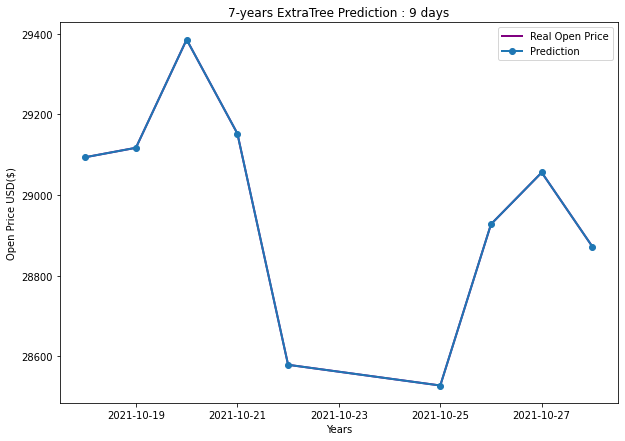



HSI 7-years
R-Sqared n_splits=5:  [0.96664687 0.96495834 0.96602632 0.96020897 0.97318027]
Negative Root Mean Squared Error:  [-563.53208539 -554.68012149 -551.68744255 -570.78264931 -497.20956391]
R-Sqared :  0.9724882894887492
Mean Squared Error :  224854.31371631884
Root Mean Squared Error :  474.18805733202396


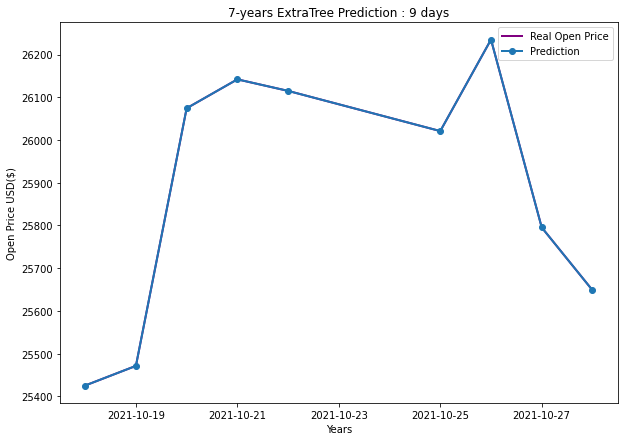



DJI 7-years
R-Sqared n_splits=5:  [0.9967616  0.99753492 0.99501238 0.99740417 0.99718   ]
Negative Root Mean Squared Error:  [-300.7663471  -256.23258565 -359.79066326 -273.46492251 -268.00569362]
R-Sqared :  0.9981239062168706
Mean Squared Error :  54526.43989070989
Root Mean Squared Error :  233.50897175635433


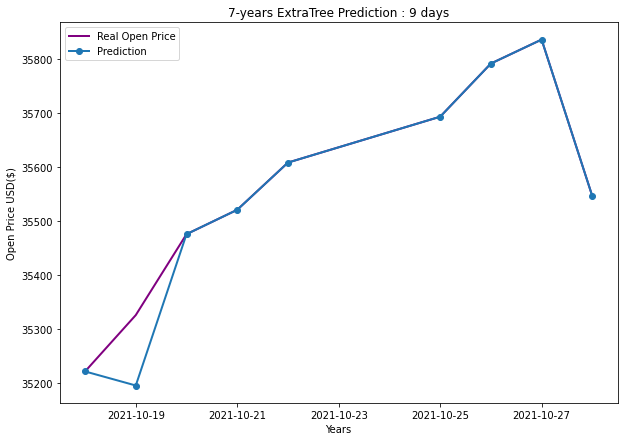



SSE 7-years
R-Sqared n_splits=5:  [0.96231616 0.9786518  0.96651347 0.96816126 0.96006463]
Negative Root Mean Squared Error:  [-82.54722473 -55.676911   -66.91451014 -68.10545628 -81.90503398]
R-Sqared :  0.9766751518651506
Mean Squared Error :  3536.8350914583853
Root Mean Squared Error :  59.4712963660486


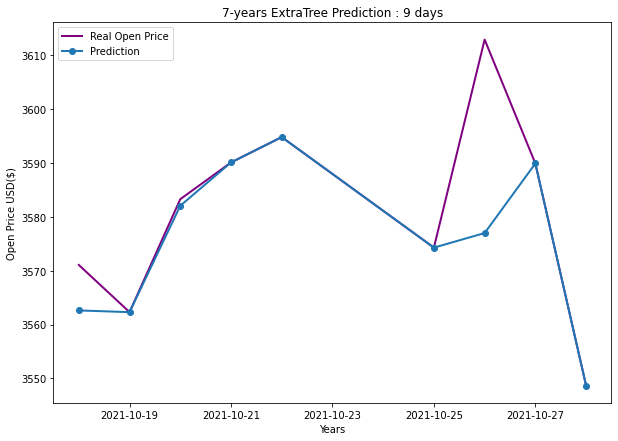

In [45]:
model_regression_train = ExtraTreesRegressor(n_estimators=100, random_state=0)
model_name  = '7-years ExtraTree'
future_d = 9
d=0

for j in training7:
    print(label[d]+" 7-years")
    reg_data = regression_predict(training7[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

## RandomForestRegressor

N225 5-years
R-Sqared n_splits=5:  [0.96107614 0.96800367 0.93357634 0.95927983 0.97105037]
Negative Root Mean Squared Error:  [-615.47401358 -564.89027584 -805.05867069 -594.51897293 -542.08052008]
R-Sqared :  0.9665115221276609
Mean Squared Error :  317994.1073843228
Root Mean Squared Error :  563.9096624321336


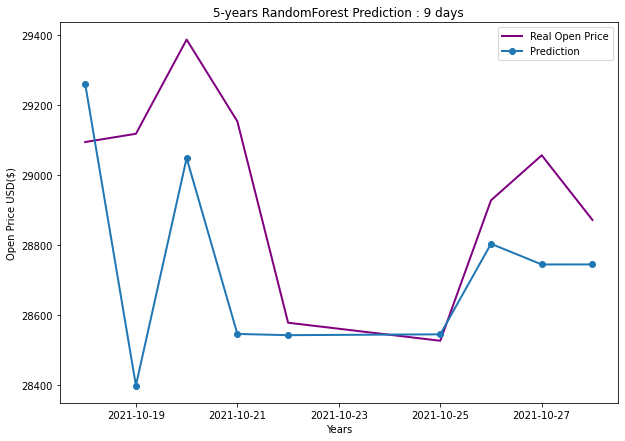



HSI 5-years
R-Sqared n_splits=5:  [0.91460548 0.89070406 0.89785085 0.8855815  0.87484772]
Negative Root Mean Squared Error:  [-675.82111909 -674.18121955 -674.56989988 -729.90941613 -740.68957577]
R-Sqared :  0.9120770971213362
Mean Squared Error :  352187.0918782399
Root Mean Squared Error :  593.4535296703862


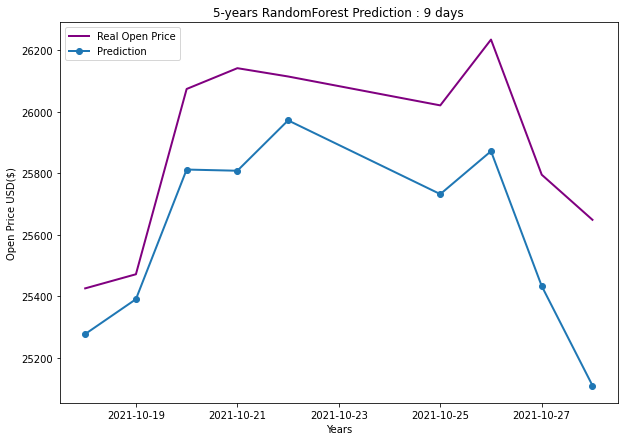



DJI 5-years
R-Sqared n_splits=5:  [0.97084208 0.97719912 0.98830492 0.98793193 0.98837449]
Negative Root Mean Squared Error:  [-638.77365725 -564.73586851 -436.95511274 -440.84820355 -430.64341549]
R-Sqared :  0.9888915105408289
Mean Squared Error :  196811.9782429433
Root Mean Squared Error :  443.63496057337875


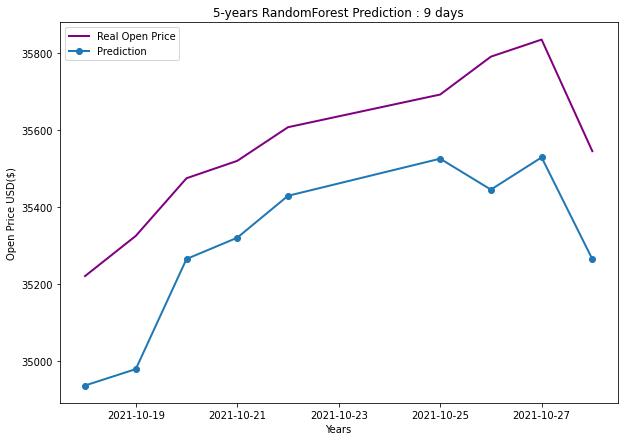



SSE 5-years
R-Sqared n_splits=5:  [0.94834549 0.95738891 0.95899331 0.95088291 0.96667057]
Negative Root Mean Squared Error:  [-66.69623706 -58.40894554 -59.9739335  -67.11265053 -53.05418732]
R-Sqared :  0.9609915714172669
Mean Squared Error :  3219.2041591653724
Root Mean Squared Error :  56.738030977161806


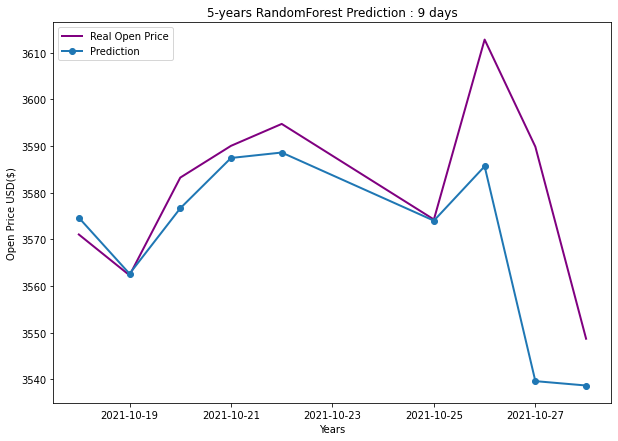

In [46]:
model_regression_train = RandomForestRegressor(n_estimators=100, random_state=0)
model_name  = '5-years RandomForest'
future_d = 9
d=0

for j in training5:
    print(label[d]+" 5-years")
    reg_data = regression_predict(training5[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

N225 7-years
R-Sqared n_splits=5:  [0.96883625 0.97496521 0.97967819 0.97737951 0.97250082]
Negative Root Mean Squared Error:  [-616.40110179 -576.43441268 -501.92336599 -506.29908429 -584.57424754]
R-Sqared :  0.9740971532680628
Mean Squared Error :  337443.04492533597
Root Mean Squared Error :  580.8984807393939


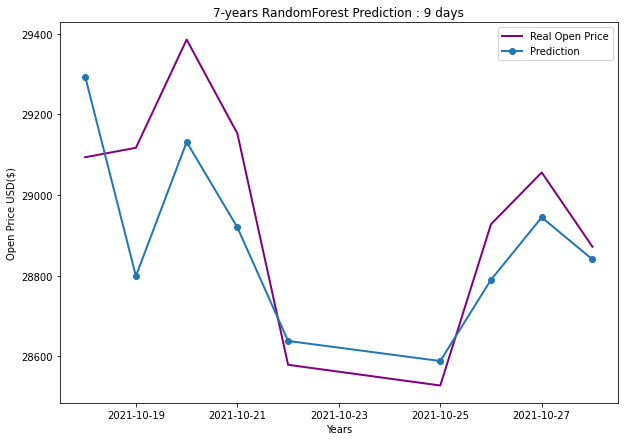



HSI 7-years
R-Sqared n_splits=5:  [0.95424519 0.93906775 0.96688681 0.96479481 0.95778347]
Negative Root Mean Squared Error:  [-618.94979281 -688.07804545 -533.03062313 -563.5744247  -613.68181111]
R-Sqared :  0.9764492271923988
Mean Squared Error :  240139.1030002313
Root Mean Squared Error :  490.03989939619333


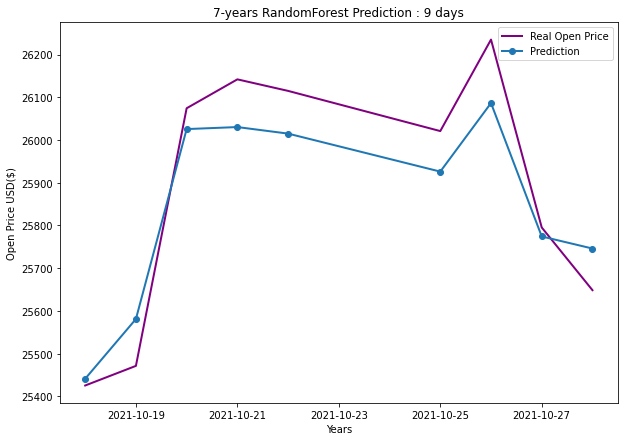



DJI 7-years
R-Sqared n_splits=5:  [0.99511202 0.99142162 0.99154001 0.98958619 0.99181073]
Negative Root Mean Squared Error:  [-372.09996855 -481.250553   -492.17732972 -537.93494505 -480.36662981]
R-Sqared :  0.9864183455671472
Mean Squared Error :  328697.3651790409
Root Mean Squared Error :  573.3213454765494


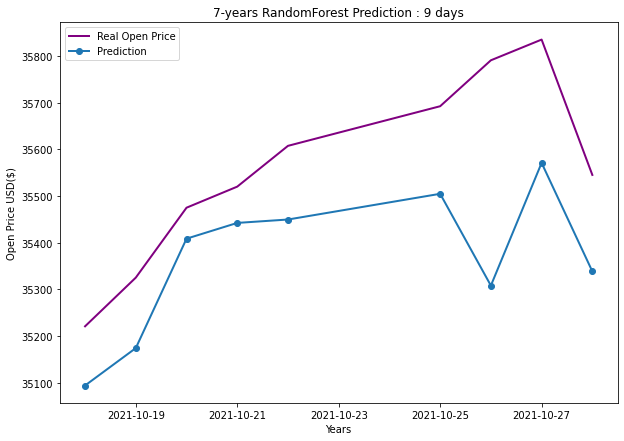



SSE 7-years
R-Sqared n_splits=5:  [0.94491058 0.9602102  0.9562228  0.93186745 0.95940539]
Negative Root Mean Squared Error:  [-94.6773997  -80.98699536 -95.70643725 -92.79183598 -74.45643303]
R-Sqared :  0.949230252731143
Mean Squared Error :  6234.356743186482
Root Mean Squared Error :  78.9579428758531


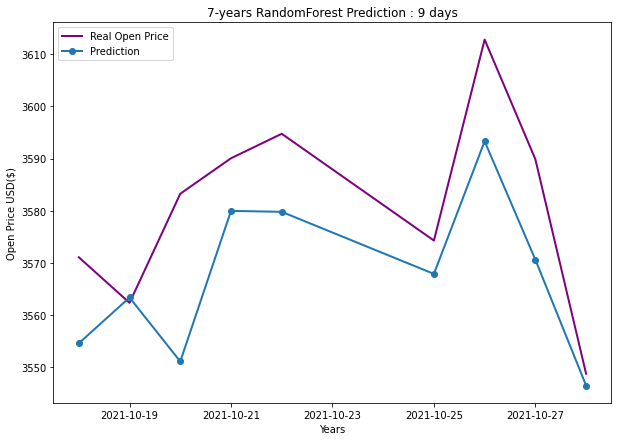

In [47]:
model_regression_train = RandomForestRegressor(n_estimators=100, random_state=0)
model_name  = '7-years RandomForest'
future_d = 9
d=0

for j in training7:
    print(label[d]+" 7-years")
    reg_data = regression_predict(training7[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

## AdaBoostRegressor

N225 5-years
R-Sqared n_splits=5:  [0.94273241 0.94515357 0.91151501 0.93834016 0.93602109]
Negative Root Mean Squared Error:  [-727.21930957 -787.81350285 -876.73442734 -789.1834466  -772.70575247]
R-Sqared :  0.9462604852843497
Mean Squared Error :  465262.9786158709
Root Mean Squared Error :  682.1018828707855


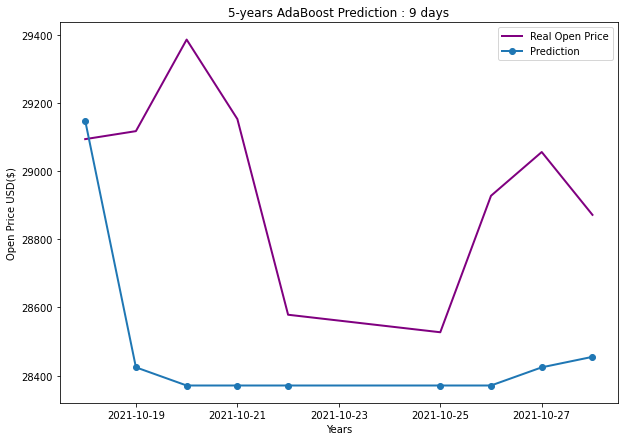



HSI 5-years
R-Sqared n_splits=5:  [0.83500567 0.80350042 0.80873295 0.82808355 0.82976767]
Negative Root Mean Squared Error:  [-890.63903997 -883.2413113  -958.58644395 -853.64943663 -864.63035703]
R-Sqared :  0.8434314916752175
Mean Squared Error :  743615.8962905178
Root Mean Squared Error :  862.3316625814674


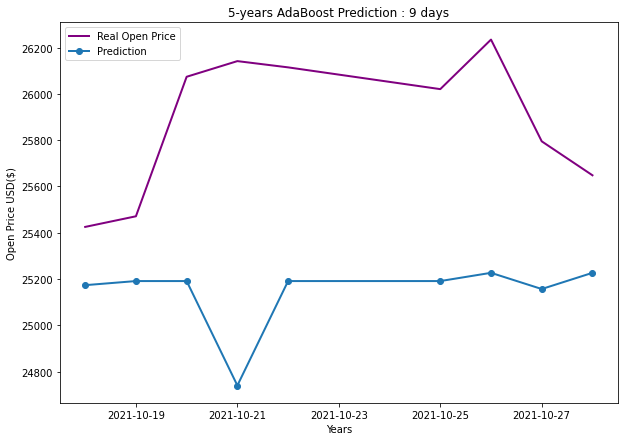



DJI 5-years
R-Sqared n_splits=5:  [0.96297817 0.97249045 0.95990938 0.96658078 0.96624494]
Negative Root Mean Squared Error:  [-724.39523676 -676.13687881 -778.62631176 -760.03674522 -746.2788747 ]
R-Sqared :  0.9609019367935727
Mean Squared Error :  569082.256434793
Root Mean Squared Error :  754.3754081588245


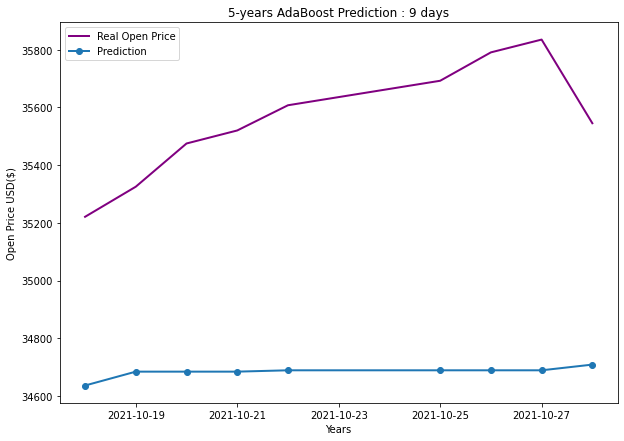



SSE 5-years
R-Sqared n_splits=5:  [0.92853357 0.90909492 0.92407238 0.90987251 0.91865091]
Negative Root Mean Squared Error:  [-80.23480153 -84.40989558 -82.95499998 -88.1000399  -85.19371792]
R-Sqared :  0.8979801201239568
Mean Squared Error :  7801.779625550356
Root Mean Squared Error :  88.32768323436518


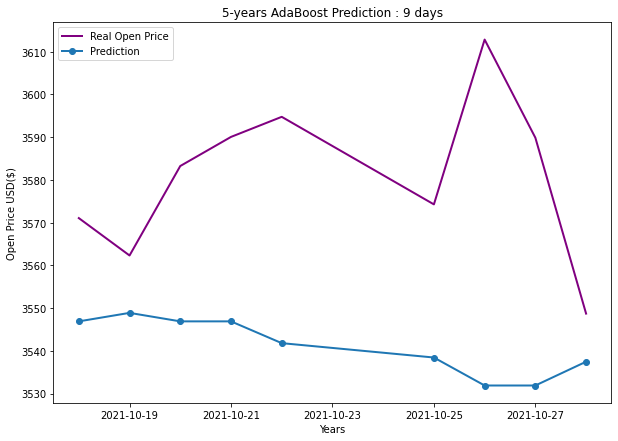

In [48]:
Dtr_ada = DecisionTreeRegression()
model_regression_train = AdaBoostRegressor(base_estimator = Dtr_ada,n_estimators=100, random_state=0,learning_rate=1)
model_name  = '5-years AdaBoost'
future_d = 9
d=0

for j in training5:
    print(label[d]+" 5-years")
    reg_data = regression_predict(training5[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

N225 7-years
R-Sqared n_splits=5:  [0.94950056 0.95157486 0.95379655 0.95863855 0.95088942]
Negative Root Mean Squared Error:  [-765.26776099 -783.86451398 -747.00109467 -742.97016483 -800.00415261]
R-Sqared :  0.9443792395163788
Mean Squared Error :  652268.3081101625
Root Mean Squared Error :  807.631294657508


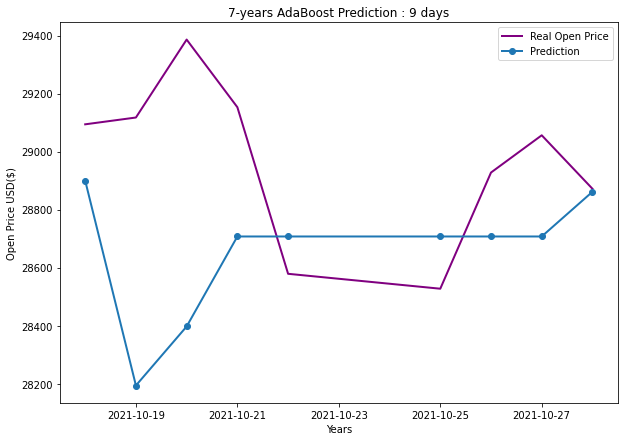



HSI 7-years
R-Sqared n_splits=5:  [0.91311808 0.90770285 0.90170499 0.90072488 0.92898748]
Negative Root Mean Squared Error:  [-837.62368472 -884.76864455 -947.83884041 -945.28159619 -836.07190532]
R-Sqared :  0.9068930463130003
Mean Squared Error :  776998.0621262789
Root Mean Squared Error :  881.4749356199976


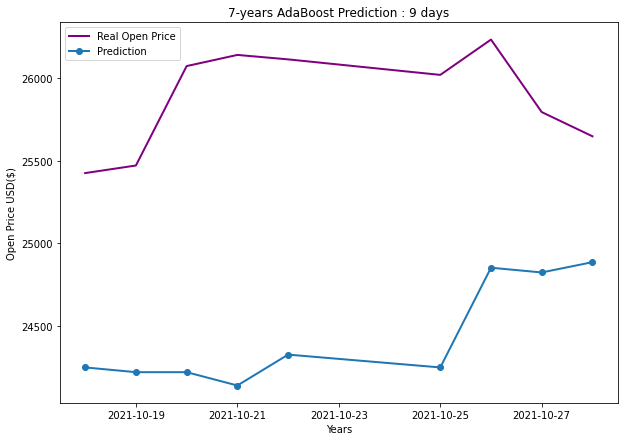



DJI 7-years
R-Sqared n_splits=5:  [0.98040989 0.9790295  0.98314751 0.98049624 0.98204037]
Negative Root Mean Squared Error:  [-726.03799146 -745.22420348 -667.61682869 -717.93539706 -730.99764494]
R-Sqared :  0.9803776070655217
Mean Squared Error :  553808.2819237639
Root Mean Squared Error :  744.1829626669532


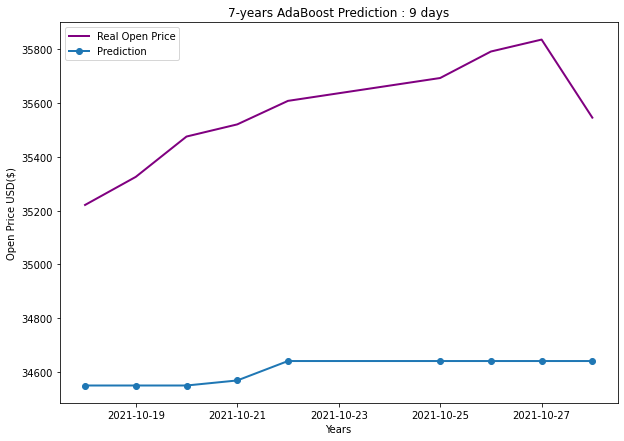



SSE 7-years
R-Sqared n_splits=5:  [0.83301041 0.8554112  0.9004747  0.88608776 0.85172311]
Negative Root Mean Squared Error:  [-146.16923325 -141.5691387  -128.97774475 -144.96700804 -142.91313943]
R-Sqared :  0.8929268373152202
Mean Squared Error :  17753.496137467613
Root Mean Squared Error :  133.24224606883365


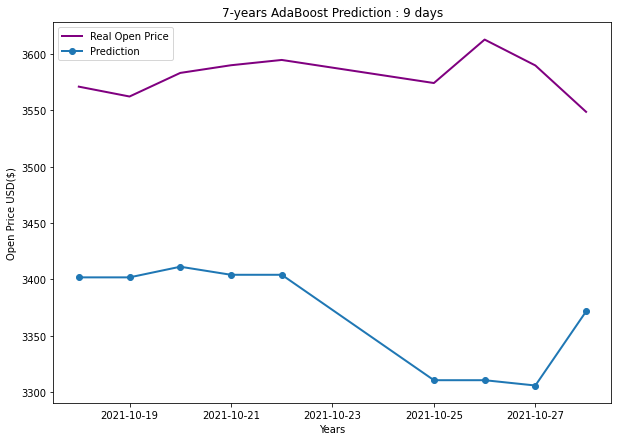

In [49]:
Dtr_ada = DecisionTreeRegression()
model_regression_train = AdaBoostRegressor(base_estimator = Dtr_ada,n_estimators=100, random_state=0,learning_rate=1)
model_name  = '7-years AdaBoost'
future_d = 9
d=0

for j in training7:
    print(label[d]+" 7-years")
    reg_data = regression_predict(training7[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

## GradientBoostingRegressor

N225 5-years
R-Sqared n_splits=5:  [0.97149961 0.97499015 0.96943824 0.96699432 0.96545098]
Negative Root Mean Squared Error:  [-539.47113984 -481.05796558 -550.2447282  -567.10330184 -580.05996501]
R-Sqared :  0.9592433466730778
Mean Squared Error :  361121.369323762
Root Mean Squared Error :  600.9337478655713


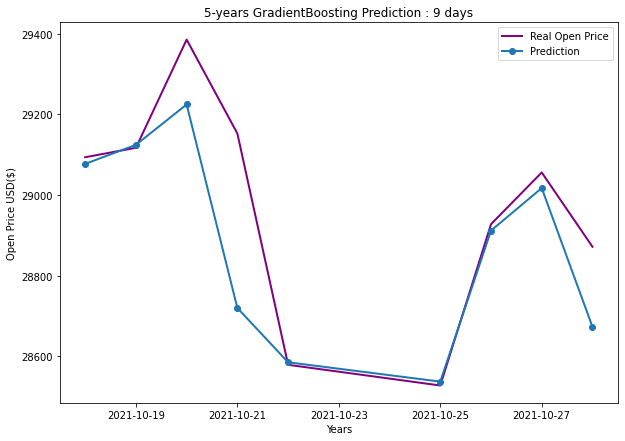



HSI 5-years
R-Sqared n_splits=5:  [0.91104252 0.87980907 0.84371484 0.91490244 0.91236139]
Negative Root Mean Squared Error:  [-637.77785663 -706.99221289 -814.61567753 -589.66418135 -659.08975882]
R-Sqared :  0.9328814538593118
Mean Squared Error :  332120.03894118516
Root Mean Squared Error :  576.2985675335183


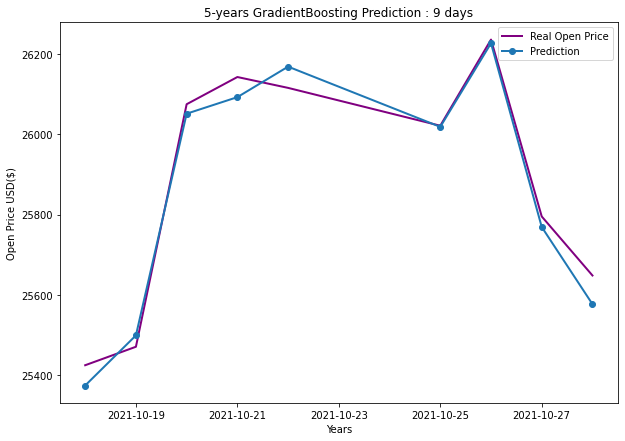



DJI 5-years
R-Sqared n_splits=5:  [0.98624477 0.97711894 0.98766756 0.99116041 0.98407885]
Negative Root Mean Squared Error:  [-494.06614918 -598.2997787  -441.14797926 -372.25737414 -485.88755978]
R-Sqared :  0.9914044512631704
Mean Squared Error :  126651.99029169316
Root Mean Squared Error :  355.8819892769135


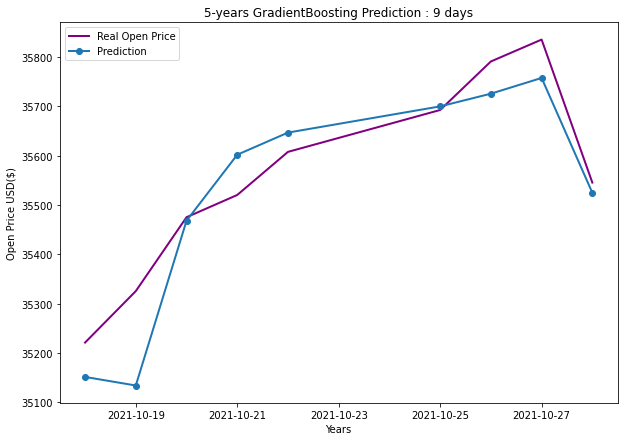



SSE 5-years
R-Sqared n_splits=5:  [0.95152286 0.96473031 0.95322151 0.96719845 0.94906983]
Negative Root Mean Squared Error:  [-66.31550287 -53.3913622  -60.75340379 -54.86051788 -63.32025231]
R-Sqared :  0.9783037660439817
Mean Squared Error :  1950.821085347934
Root Mean Squared Error :  44.16810031400416


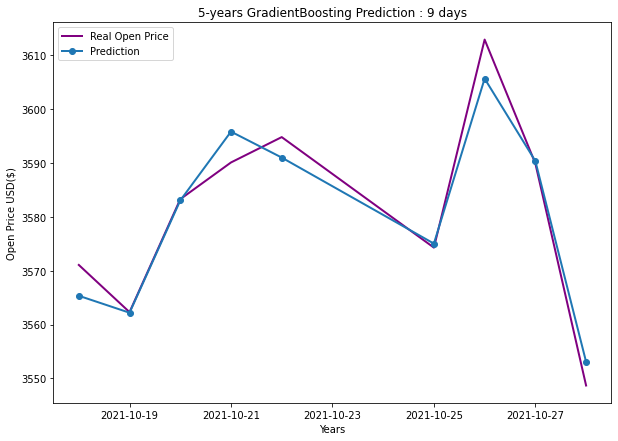

In [50]:
model_regression_train = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0,min_samples_split=0.005,min_samples_leaf=0.005)
model_name  = '5-years GradientBoosting'
future_d = 9
d=0

for j in training5:
    print(label[d]+" 5-years")
    reg_data = regression_predict(training5[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")


N225 7-years
R-Sqared n_splits=5:  [0.96071749 0.96008784 0.97275761 0.9653605  0.97924955]
Negative Root Mean Squared Error:  [-667.09427931 -717.57883516 -584.93858383 -633.46022711 -535.90323155]
R-Sqared :  0.9706224854032626
Mean Squared Error :  365472.7577150862
Root Mean Squared Error :  604.5434291389546


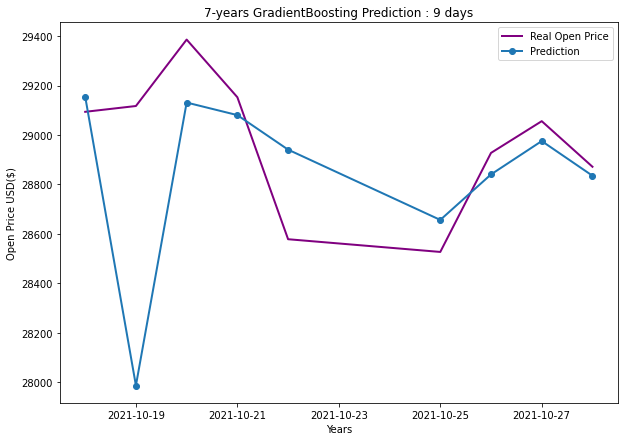



HSI 7-years
R-Sqared n_splits=5:  [0.95735588 0.9632616  0.96070655 0.96383977 0.96342463]
Negative Root Mean Squared Error:  [-626.53370232 -562.12489987 -580.16916636 -559.94369649 -578.94644592]
R-Sqared :  0.9550789425971989
Mean Squared Error :  380395.9000245906
Root Mean Squared Error :  616.7624340251201


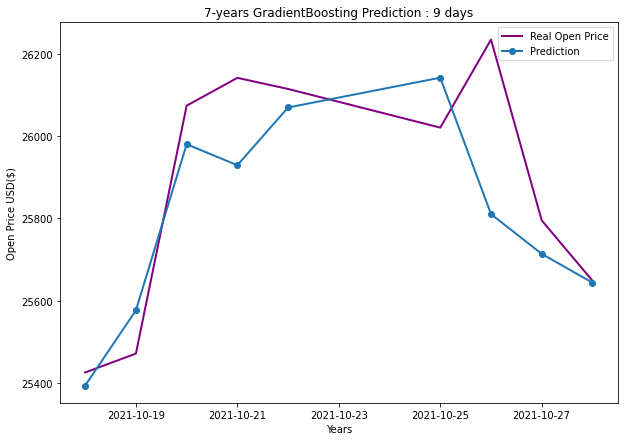



DJI 7-years
R-Sqared n_splits=5:  [0.99425158 0.99458744 0.99428733 0.99116029 0.98961472]
Negative Root Mean Squared Error:  [-409.73142153 -380.30273257 -401.54514951 -474.39932039 -519.57571386]
R-Sqared :  0.9953646568898289
Mean Squared Error :  133640.1972083556
Root Mean Squared Error :  365.56832084899753


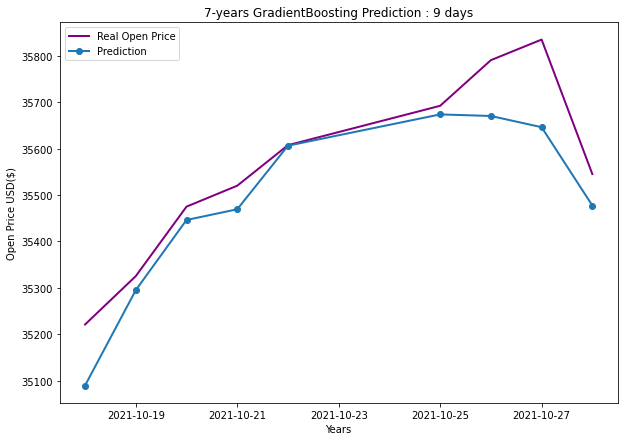



SSE 7-years
R-Sqared n_splits=5:  [0.96485722 0.93439359 0.97298026 0.95523123 0.93175395]
Negative Root Mean Squared Error:  [ -77.50156353 -110.31245252  -63.82960535  -66.96912044 -113.2716471 ]
R-Sqared :  0.9671558954954831
Mean Squared Error :  4168.123767961185
Root Mean Squared Error :  64.56100810830935


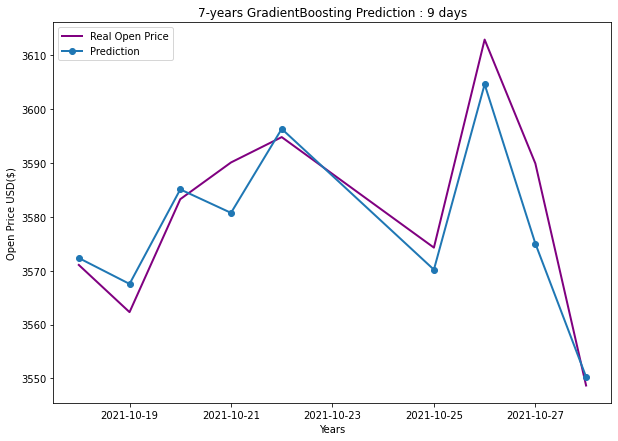

In [51]:
model_regression_train = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0,min_samples_split=0.005,min_samples_leaf=0.005)
model_name  = '7-years GradientBoosting'
future_d = 9
d=0

for j in training7:
    print(label[d]+" 7-years")
    reg_data = regression_predict(training7[d],model_regression_train,model_name,future_d)
    d=d+1
    print("\n")

# Forecasting

#### Variable Assign

In [52]:
N225y5 = pdr.get_data_yahoo("^N225", start="2013-12-31", end="2018-12-31")

N225y7 = pdr.get_data_yahoo("^N225", start="2011-12-31", end="2018-12-31")

HSIy5 = pdr.get_data_yahoo("^HSI", start="2013-12-31", end="2018-12-31")

HSIy7 = pdr.get_data_yahoo("^HSI", start="2011-12-31", end="2018-12-31")

DJIy5 = pdr.get_data_yahoo("^DJI", start="2013-12-31", end="2018-12-31")

DJIy7 = pdr.get_data_yahoo("^DJI", start="2011-12-31", end="2018-12-31")

SSEy5 = pdr.get_data_yahoo("000001.SS", start="2013-12-31", end="2018-12-31")

SSEy7 = pdr.get_data_yahoo("000001.SS", start="2011-12-31", end="2018-12-31")

In [53]:
#Techno
ATTy5 = pdr.get_data_yahoo("T", start="2016-10-31", end="2021-10-31")
AAPLy5 = pdr.get_data_yahoo("AAPL", start="2016-10-31", end="2021-10-31")
MRVLy5 = pdr.get_data_yahoo("MRVL", start="2016-10-31", end="2021-10-31")
FORDy5 = pdr.get_data_yahoo("F", start="2016-10-31", end="2021-10-31")
AMDy5 = pdr.get_data_yahoo("AMD", start="2016-10-31", end="2021-10-31")

#health
PFEy5 = pdr.get_data_yahoo("PFE", start="2016-10-31", end="2021-10-31")
BMYy5 = pdr.get_data_yahoo("BMY", start="2016-10-31", end="2021-10-31")
UNHy5 = pdr.get_data_yahoo("UNH", start="2016-10-31", end="2021-10-31")
JNJy5 = pdr.get_data_yahoo("JNJ", start="2016-10-31", end="2021-10-31")
NVOy5 = pdr.get_data_yahoo("NVO", start="2016-10-31", end="2021-10-31")

#Entertainment
CCLy5 =  pdr.get_data_yahoo("CCL", start="2016-10-31", end="2021-10-31")
AMCy5 = pdr.get_data_yahoo("AMC", start="2016-10-31", end="2021-10-31")
AALy5 = pdr.get_data_yahoo("AAL", start="2016-10-31", end="2021-10-31")
ZNGAy5 = pdr.get_data_yahoo("ZNGA", start="2016-10-31", end="2021-10-31")
PBRy5 = pdr.get_data_yahoo("PBR", start="2016-10-31", end="2021-10-31")

#power
FCELy5 = pdr.get_data_yahoo("FCEL", start="2016-10-31", end="2021-10-31")
SWNy5 = pdr.get_data_yahoo("SWN", start="2016-10-31", end="2021-10-31")
PLUGy5 = pdr.get_data_yahoo("PLUG", start="2016-10-31", end="2021-10-31")
MROy5 = pdr.get_data_yahoo("MRO", start="2016-10-31", end="2021-10-31")
ETy5 = pdr.get_data_yahoo("ET", start="2016-10-31", end="2021-10-31")

#industry
FMCy5 = pdr.get_data_yahoo("F", start="2016-10-31", end="2021-10-31")
VALEy5 = pdr.get_data_yahoo("VALE", start="2016-10-31", end="2021-10-31")
CCLy5 = pdr.get_data_yahoo("CCL", start="2016-10-31", end="2021-10-31")
PDDy5 = pdr.get_data_yahoo("PDD", start="2016-10-31", end="2021-10-31")
GMy5 = pdr.get_data_yahoo("GM", start="2016-10-31", end="2021-10-31")



In [54]:
Ni = pdr.get_data_yahoo("^N225", start="2016-12-31", end="2021-10-31")
Hi = pdr.get_data_yahoo("^HSI", start="2016-12-31", end="2021-10-31")
Di = pdr.get_data_yahoo("^DJI", start="2016-12-31", end="2021-10-31")
Si = pdr.get_data_yahoo("000001.SS", start="2016-12-31", end="2021-10-31")

In [55]:
def add(df):
    data = df.copy()
    
    next = 7
    for i in range(3):
        if (i == 0):
            data_compare = data.copy()
        data_compare["{}".format(i+next)] = data_compare.Close.shift(-i-next)
        
    percent = 0.0175
    conditions = [
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) > data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) > data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) > data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) <= -data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) <= -data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) <= -data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(0+next)]) <= data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(1+next)]) <= data_compare['Open']*percent),
    ((data_compare['Open']-data_compare['{}'.format(2+next)]) <= data_compare['Open']*percent)
    ]
    values = [2,2,2,0,0,0,1,1,1]
    data['Target'] = np.select(conditions, values)
    data.dropna(inplace=True)
    print(data[data["Target"] == 1]["Open"].count(),data[data["Target"] == 2]["Open"].count(),data[data["Target"] == 0]["Open"].count())
    return data

In [56]:
def addindicator(df):
    data = df.copy()
    data['SMA20'] = talib.SMA(data['Close'], timeperiod=14)
    data['MACD'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0] / \
                     talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0].mean()
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14) / talib.RSI(data['Close'], timeperiod=14).mean()
    data['EMA'] = talib.EMA(data['Close'], timeperiod=14)
    data['CMO'] = talib.CMO(data['Close'], timeperiod=14)
    data['slowk'], data['slowd'] = talib.STOCH(high=data['High'],
                                low=data['Low'],
                                fastk_period=9,
                                close=data['Close'],
                                slowk_period=3,
                                slowk_matype=0,
                                slowd_period=6,
                                slowd_matype=0)
    data['OBV'] = talib.OBV(data["Close"], data["Volume"])
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['ADOSC'] = talib.ADOSC(data['High'], data['Low'], data['Close'], data["Volume"], fastperiod=3, slowperiod=10)
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['HT_DCPHASE'] = talib.HT_DCPHASE(data['Close'])
    data['APO'] = talib.APO(data['Close'], fastperiod=12, slowperiod=26, matype=0)
    data.dropna(inplace=True)
    return data

In [57]:
N225y5 = add(N225y5)
N225y7 = add(N225y7)
HSIy5 = add(HSIy5)
HSIy7 = add(HSIy7)
DJIy5 = add(DJIy5)
DJIy7 = add(DJIy7)
SSEy5 = add(SSEy5)
SSEy7 = add(SSEy7)

357 374 495
427 531 761
354 400 478
490 562 669
641 260 359
874 352 535
388 347 485
492 541 667


In [58]:
ATTy5 = add(ATTy5)
AAPLy5 = add(AAPLy5)
MRVLy5 = add(MRVLy5)
FORDy5 = add(FORDy5)
AMDy5 = add(AMDy5)

PFEy5 = add(PFEy5)
BMYy5 = add(BMYy5)
UNHy5 = add(UNHy5)
JNJy5 = add(JNJy5)
NVOy5 = add(NVOy5)

CCLy5 = add(CCLy5)
AMCy5 = add(AMCy5)
AALy5 = add(AALy5)
ZNGAy5 = add(ZNGAy5)
PBRy5 = add(PBRy5)

FCELy5 = add(FCELy5)
SWNy5 = add(SWNy5)
PLUGy5 = add(PLUGy5)
MROy5 = add(MROy5)
ETy5 = add(ETy5)

FMCy5 = add(FMCy5)
VALEy5 = add(VALEy5)
CCLy5 = add(CCLy5)
PDDy5 = add(PDDy5)
GMy5 = add(GMy5)

346 479 434
191 361 707
137 499 623
186 538 535
51 521 687
363 380 516
266 460 533
304 369 586
389 373 497
239 393 627
192 524 543
52 694 513
81 637 541
152 484 623
59 578 622
25 737 497
19 714 526
57 618 584
79 616 564
160 589 510
186 538 535
75 588 596
192 524 543
22 400 401
145 569 545


In [59]:
Ni = add(Ni)
Hi = add(Hi)
Di = add(Di)
Si = add(Si)

411 330 438
307 392 490
532 236 449
465 310 395


In [60]:
N225y5_ind = addindicator(N225y5)
HSIy5_ind = addindicator(HSIy5)
DJIy5_ind = addindicator(DJIy5)
SSEy5_ind = addindicator(SSEy5)
N225y7_ind = addindicator(N225y7)
HSIy7_ind = addindicator(HSIy7)
DJIy7_ind = addindicator(DJIy7)
SSEy7_ind = addindicator(SSEy7)

In [61]:
ATTy5_ind = addindicator(ATTy5)
AAPLy5_ind = addindicator(AAPLy5)
MRVLy5_ind = addindicator(MRVLy5)
FORDy5_ind = addindicator(FORDy5)
AMDy5_ind = addindicator(AMDy5)

PFEy5_ind = addindicator(PFEy5)
BMYy5_ind = addindicator(BMYy5)
UNHy5_ind = addindicator(UNHy5)
JNJy5_ind = addindicator(JNJy5)
NVOy5_ind = addindicator(NVOy5)

CCLy5_ind = addindicator(CCLy5)
AMCy5_ind = addindicator(AMCy5)
AALy5_ind = addindicator(AALy5)
ZNGAy5_ind = addindicator(ZNGAy5)
PBRy5_ind = addindicator(PBRy5)

FCELy5_ind = addindicator(FCELy5)
SWNy5_ind = addindicator(SWNy5)
PLUGy5_ind = addindicator(PLUGy5)
MROy5_ind = addindicator(MROy5)
ETy5_ind = addindicator(ETy5)

FMCy5_ind = addindicator(FMCy5)
VALEy5_ind = addindicator(VALEy5)
CCLy5_ind = addindicator(CCLy5)
PDDy5_ind = addindicator(PDDy5)
GMy5_ind = addindicator(GMy5)

In [62]:
Ni_ind = addindicator(Ni)
Hi_ind = addindicator(Hi)
Di_ind = addindicator(Di)
Si_ind = addindicator(Si)

In [63]:
all_d = [N225y5, HSIy5, DJIy5, SSEy5, N225y7, HSIy7, DJIy7, SSEy7]
training5 = [N225y5_ind, HSIy5_ind, DJIy5_ind, SSEy5_ind]
training7 = [N225y7_ind, HSIy7_ind, DJIy7_ind, SSEy7_ind]
ind_list = ['SMA20','MACD','RSI','EMA','CMO','slowk','slowd','OBV','ADX', 'ADOSC', 'ATR', 'HT_DCPHASE', 'APO']
Techno = [ATTy5_ind, AAPLy5_ind, MRVLy5_ind, FORDy5_ind, AMDy5_ind]
Health = [PFEy5_ind, BMYy5_ind, UNHy5_ind, JNJy5_ind, NVOy5_ind]
Entertrain = [CCLy5_ind, AMCy5_ind, AALy5_ind, ZNGAy5_ind, PBRy5_ind]
Power =[FCELy5_ind, SWNy5_ind, PLUGy5_ind, MROy5_ind, ETy5_ind]
Industry = [FMCy5_ind, VALEy5_ind, CCLy5_ind, PDDy5_ind, GMy5_ind]
all_stock = [ATTy5_ind, AAPLy5_ind, MRVLy5_ind, FORDy5_ind, AMDy5_ind, PFEy5_ind, BMYy5_ind, UNHy5_ind, JNJy5_ind, NVOy5_ind, CCLy5_ind, AMCy5_ind, AALy5_ind, ZNGAy5_ind, PBRy5_ind, FCELy5_ind, SWNy5_ind, PLUGy5_ind, MROy5_ind, ETy5_ind, FMCy5_ind, VALEy5_ind, CCLy5_ind, PDDy5_ind, GMy5_ind]
self = [Ni_ind, Hi_ind, Di_ind, Si_ind]

## Forecast Regression & Classification Methods

#### Regression

In [64]:
def forecast_predict_re(training_data,model_regression_train,future_d):
    
    future_days = future_d
    datapredict  = training_data
    
    datapredict['Prediction']= datapredict[['Open']].shift(-future_days)
    X = datapredict.drop(['Prediction'], 1)[:-future_days]
    X = np.array(X.iloc[:,7:].values)
    y = np.array(datapredict['Prediction'])[:-future_days]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.15)
    
    regression_model = model_regression_train.fit(x_train,y_train)
    
    x_future = datapredict.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.iloc[:,7:]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)

    
    regression_prediction = regression_model.predict(x_future)
    
    y_pred = regression_model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    root_mean_squared_error = sqrt(mse)
    R_squre = r2_score(y_test,regression_model.predict(x_test))
    
    predictions = regression_prediction
    
    valid = datapredict[X.shape[0]:]
    valid['Prediction'] = predictions

    result = valid['Open']-valid['Prediction']
    valid['result']= result
    valid[valid['result']!=0][['Open','Prediction','result']]

    return valid["Prediction"].values

#### Classification

In [65]:
def forecast_train(df, model):
    scaler = StandardScaler()
    flag = 0
    total = []
    for i in df:
        data = i.copy()
        x = scaler.fit_transform(data.iloc[:,7:])
        x = pd.DataFrame(x, columns = ind_list)
        y = data.iloc[:, 6].values
        if (flag == 0):
            a_y = y
        else:
            a_y = np.concatenate((a_y, y), axis=0)
        total.append(x)
        flag += 1
    a_x = pd.concat(total)
    rfe = RFE(model)
    rfe = rfe.fit(a_x[ind_list],a_y)
    result = pd.Series(rfe.support_, index = ind_list)
    result = result[result==False].index
    a_x = a_x.drop(result, axis='columns').values
    model.fit(a_x,a_y)
    return (model, result)

def forecast_pred(df, result, model):
    scaler = StandardScaler()
    for i in df:
        data = i.copy()
        data = data.drop(result, axis='columns')
        
        x_test = data.iloc[:, 7:]
        y_test = data.iloc[:, 6].values
        s_x = scaler.fit_transform(x_test)
        y_pred = model.predict(s_x)
        pred_accur = metrics.accuracy_score(y_test, y_pred)
        pred_recall = metrics.recall_score(y_test, y_pred, average='macro')
    return y_pred

In [66]:
lsvc = LinearSVC(random_state=0, tol=1e-5,dual=False,C=1,max_iter= 2000,penalty='l2')
lsvc = forecast_train(training7, lsvc)
lda = LinearDiscriminantAnalysis(solver="svd")
lda = forecast_train(training7, lda)
lgbm = lgb.LGBMClassifier(learning_rate=0.001,max_depth=-16, max_bin= 16,num_leaves = 32, num_iterations = 1000)
lgbm = forecast_train(training7, lgbm)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0,min_samples_split=0.005,min_samples_leaf=0.005)
gb = forecast_train(training7, gb)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, eval_metric='mlogloss', use_label_encoder=False)
xgb = forecast_train(training7, xgb)
model = [lsvc, lda, lgbm, gb, xgb]
DTR = DecisionTreeRegressor()
ETR = ExtraTreesRegressor(n_estimators=100, random_state=0)
RFR = RandomForestRegressor(max_depth=2, random_state=0)
ADR = AdaBoostRegressor(random_state=0, n_estimators=100)
GBR = GradientBoostingRegressor(random_state=0)
r_model = [DTR, ETR, RFR, ADR, GBR]

## Forecasting Model

In [67]:
amount = 0
stock_set = Techno.copy()
d = date(2019,1,1)
port_stock = []
available = []
for i in range(len(stock_set)):
    available.append(i)
day = []
money_log = [[],[],[]]
buy_log = []
sell_log = []
cut_log = []
port_log = []
money = 1000000
lastest_price = []
for i in range(len(stock_set)):
    lastest_price.append([0])
for i in range(14):
    day.append(str(d))
    d += timedelta(days=1)
for i in range(370):
    buy = 0
    sell = 0
    cut = 0
    print(i, end= " ")
    for j in available:
        stock = stock_set[j]
        if (stock[stock.index == str(d)]["Open"].count() == 1):
            lastest_price[j] = stock[stock.index == str(d)]["Open"].values[0]
            a_d = []
            
            score = []
            for sd in day:
                if (stock[stock.index == str(sd)]["Open"].count() == 1):
                    a_d.append(sd)
                    
            for k in model:
                pred = forecast_pred([stock.loc[a_d]], np.array(k[1]), k[0])
                score.append(pred[-1])
                
            if(score.count(2) > len(model)/2):
                price = []
                for r in r_model:
                    box = forecast_predict_re(stock[stock.index < str(d)],r,9)
                    price.append(max(box))
                percent = (np.mean(price)-lastest_price[j])/lastest_price[j]
                if (percent > 0.02):
                    capital = money*(0.3061976-0.3061976/math.pow(2,percent/0.1027614))
                    amount = math.floor(capital/lastest_price[j])
                    money -= lastest_price[j]*amount
                    port_stock.append([lastest_price[j], 1, i, j, amount])
                    buy += amount
            elif (score.count(0) > len(model)/2):
                price = []
                for r in r_model:
                    box = forecast_predict_re(stock[stock.index < str(d)],r,9)
                    price.append(min(box))
                percent = (lastest_price[j]-np.mean(price))/lastest_price[j]
                if (percent > 0.02):
                    capital = money*(0.3061976-0.3061976/math.pow(2,percent/0.1027614))
                    amount = math.floor(capital/lastest_price[j])
                    amount = math.floor(percent)
                    money -= lastest_price[j]*amount
                    port_stock.append([lastest_price[j], -1, i, j, amount])
                    buy += amount
    if (stock[stock.index == str(d)]["Open"].count() == 1):
        for j in port_stock:
            stock = stock_set[j[3]]
            price = j
#sell
            if ((price[0]-lastest_price[price[3]])*(-price[1]) >= price[0]*0.02):
                sell += price[4]
                if (price[1] == 1):
                    money += lastest_price[price[3]]*price[4]
                else:
                    money += (2*price[0]-lastest_price[price[3]])*price[4]
                port_stock.remove(price)
#cut lose
            elif ((((price[0]-lastest_price[price[3]])*(price[1]) >= price[0]*0.1) and price[1] == -1) or (i-price[2]>= 30 and price[1] == -1)):
                cut += price[4]
                if (price[1] == 1):
                    money += lastest_price[price[3]]*price[4]
                else:
                    money += (2*price[0]-lastest_price[price[3]])*price[4]
                port_stock.remove(price)
            elif ((((price[0]-lastest_price[price[3]])*(price[1]) >= price[0]*0.1) and price[1] == 1)):
                cut += price[4]
                if (price[1] == 1):
                    money += lastest_price[price[3]]*price[4]
                else:
                    money += (2*price[0]-lastest_price[price[3]])*price[4]
                port_stock.remove(price)
    d += timedelta(days=1)
    day.append(str(d))
    day.pop(0)
    sum = money
    for i in port_stock:
        sum += lastest_price[i[3]]*i[4]
    money_log[0].append(sum)
    money_log[1].append(money)
    money_log[2].append(sum-money)
    buy_log.append(buy)
    sell_log.append(sell)
    cut_log.append(cut)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

## Ploting from Forecasting

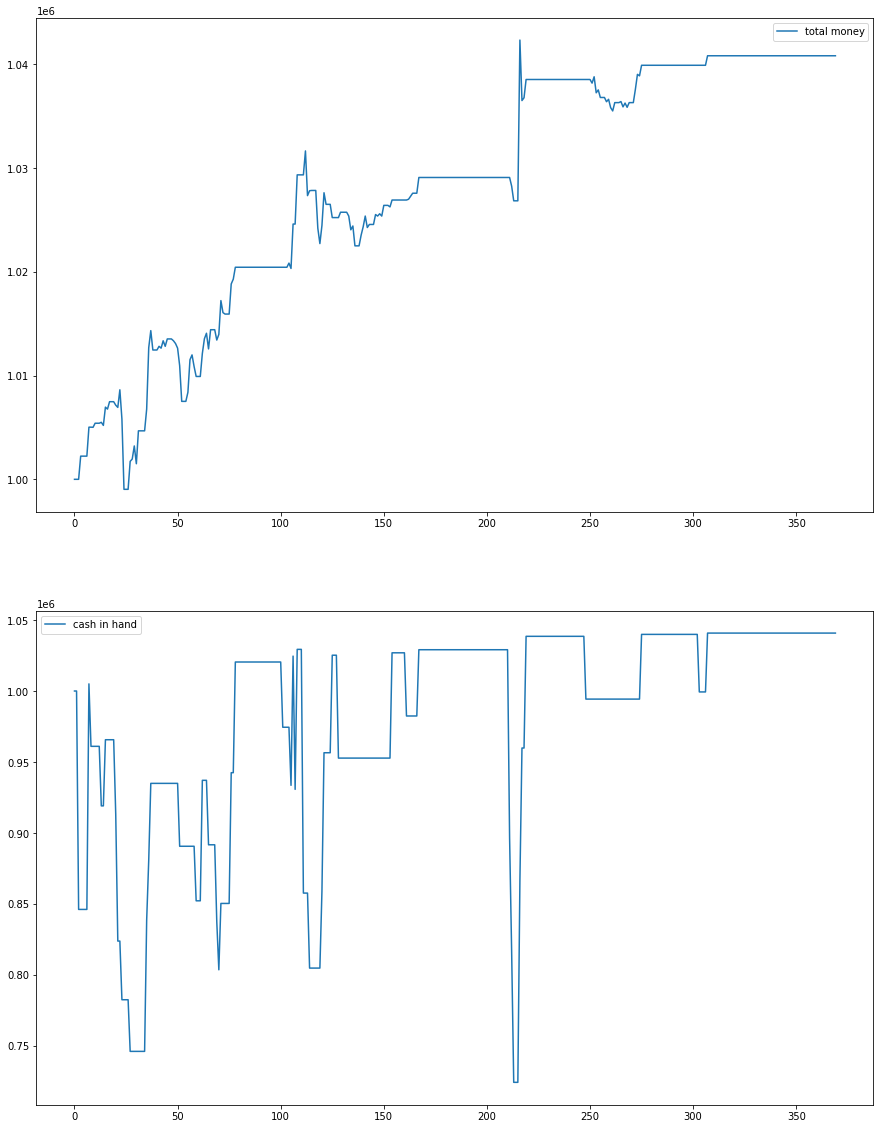

In [69]:
fig, axs = plt.subplots(2,figsize=(15,20))
d = date(2019,1,1)
d += timedelta(days=14)
his = []
for i in range(len(stock_set)):
    his.append([])
for i in range(370):
    for j in available:
        stock = stock_set[j]
        if (stock[stock.index == str(d)]["Open"].count() == 1):
            his[j].append(stock[stock.index == str(d)]["Open"].values[0])
        else:
            his[j].append(his[j][-1])
    d += timedelta(days=1)
axs[0].plot(money_log[0],"-",label='total money')

axs[0].legend()
axs[1].plot(money_log[1],"-",label='cash in hand')
axs[1].legend()
plt.show()